In [1]:
import os
import numpy as np
import torch
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.nn.functional as F
from lib.dataset_custom import KernDataset,DatasetSplit
from lib.model import ScoreModel
from lib.opt import optimize
from lib.CrossValidation import CrossValidator
from lib.config import corpora_for_classification_all_composers as default_corpora
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='3'
#os.environ['CUDA_LAUNCH_BLOCKING']='1'

checkpoint_dir = '_hybrid_reasonable_context250_cv'
context = 250
corpora = tuple(default_corpora)

In [3]:
class Convnet(ScoreModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def define_graph(self, debug=False):
        self.kernel_width = 1 # window with which we scan over time
        self.k = k = 512
        self.wnotes = Parameter(Tensor(64, 1, self.kernel_width,6,self.m//2))
        self.wnotes2 = Parameter(Tensor(k, 64, self.kernel_width))
        self.wdur = Parameter(Tensor(k, 6*self.maxdur, self.kernel_width))
        self.wtop = Parameter(Tensor(k, self.composers))
        
        self.km = km = 256
        
        self.wnotesm = Parameter(Tensor(km, self.m, 1, 3))
        self.wdurationm = Parameter(Tensor(km, self.maxdur, 1, 3))
        self.w2m = Parameter(Tensor(km, km, 1, 3))
        self.wtopm = Parameter(Tensor(km, self.composers))
        
        self.bias = Parameter(Tensor(self.composers))
    
    def forward(self, x):
        e,t,_,_ = x
        batch_size = e.shape[0]
        zn1 = F.relu(F.conv3d(e.view(batch_size*3,1,context,6,self.m),self.wnotes)).sum(4)
        z1 = F.relu(F.conv1d(zn1.transpose(2,3).contiguous().view(batch_size*3,64,-1),self.wnotes2) \
           + F.conv1d(t.transpose(2,4).contiguous().view(batch_size*3,self.maxdur*6,-1),self.wdur))
        z1 = z1.view(batch_size,3,self.k,context).mean(1).mean(2)
        
        z1m = F.relu(F.conv2d(e.view(batch_size*3,context,6,self.m).transpose(1,3),self.wnotesm) \
            + F.conv2d(t.view(batch_size*3,context,6,self.maxdur).transpose(1,3),self.wdurationm))
        z2m = F.relu(F.conv2d(z1m,self.w2m))
        z2m = z2m.view(batch_size,3,self.km,-1).mean(1).mean(2)
        
        return torch.mm(z1, self.wtop) \
             + torch.mm(z2m, self.wtopm) \
             + self.bias[None,:].expand(e.shape[0],-1)

---------------------------------------------
---------------------------------------------
Fold 0
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 20]) (10240)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 20]) (5120)
bias torch.Size([20]) (20)
Initialized graph with 530836 parameters
Initiating optimizer, 62 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
4.00    2.60    0       4.32    4.32    3.49    2.48    
44.00   46.32   62      2.50    2.57    8.79    2.44    
62.00   59.31   124     1.66    1.79    8.26    2.83    
67.00   63.64   186     1.36    1.48    8.40 

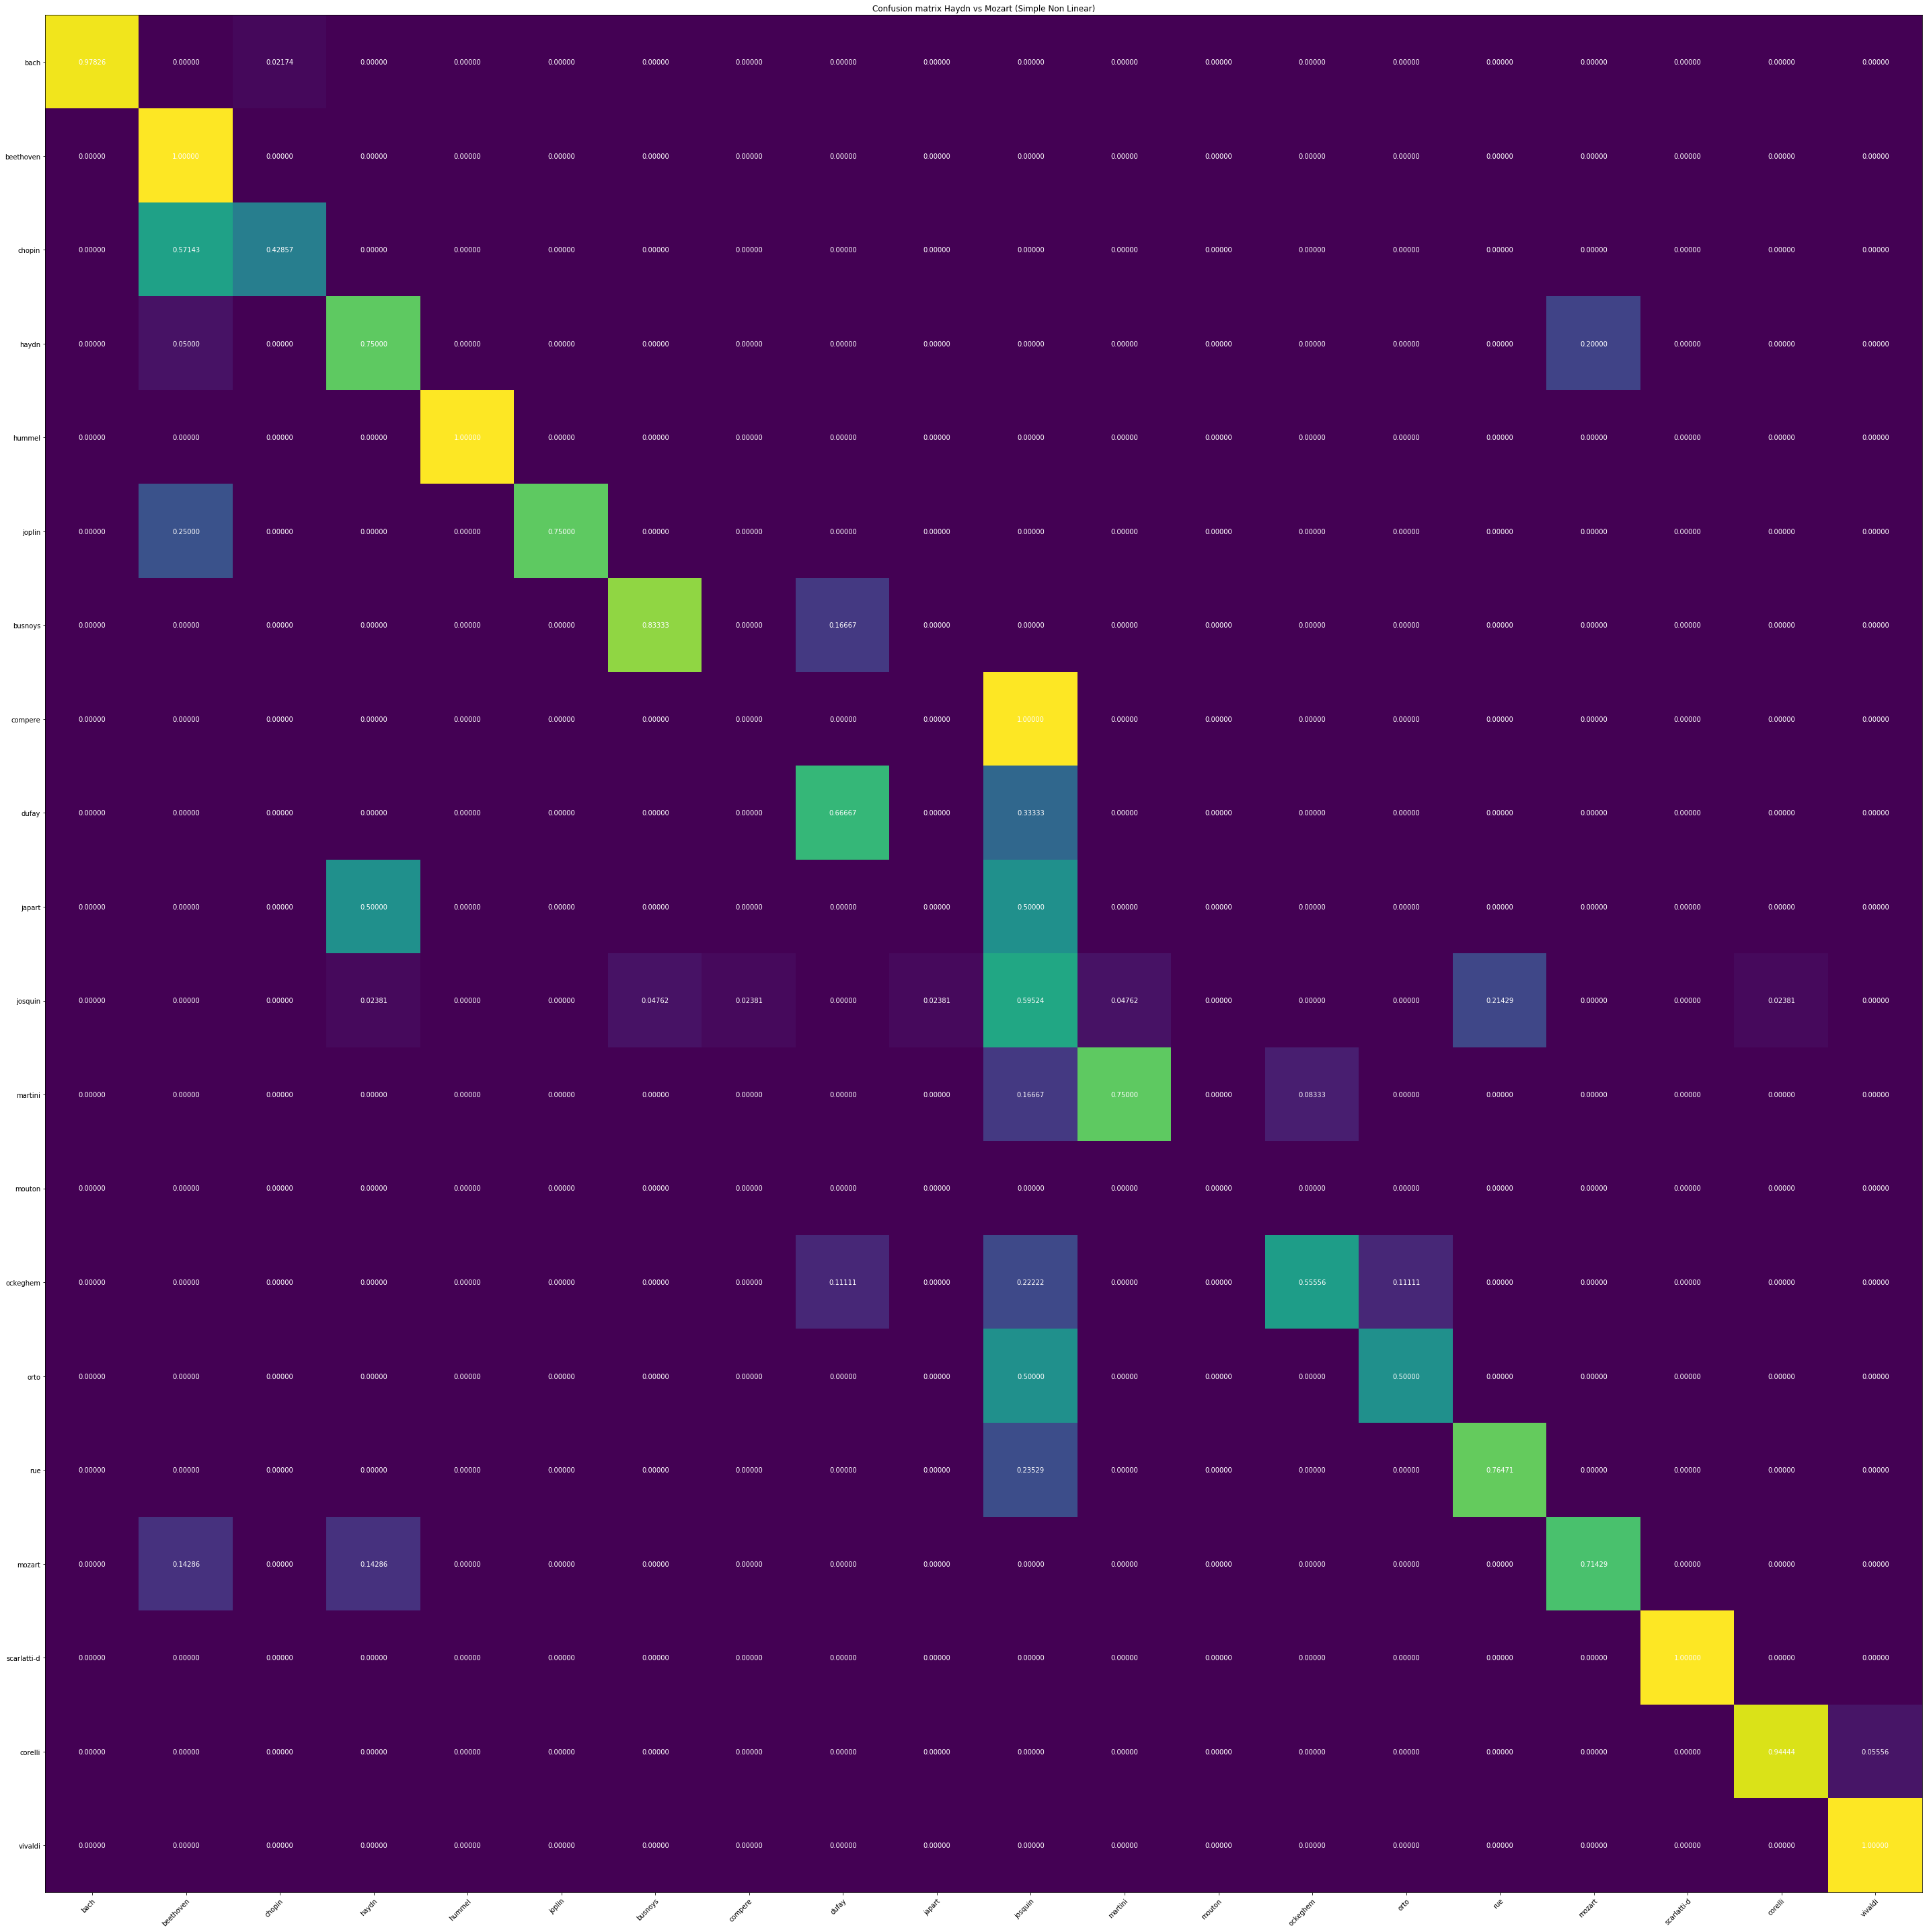

bach 45 / 46 = 0.9782608695652174
beethoven 16 / 16 = 1.0
busnoys 5 / 6 = 0.8333333333333334
chopin 3 / 7 = 0.42857142857142855
compere 0 / 2 = 0.0
corelli 17 / 18 = 0.9444444444444444
dufay 2 / 3 = 0.6666666666666666
haydn 15 / 20 = 0.75
hummel 2 / 2 = 1.0
japart 0 / 2 = 0.0
joplin 3 / 4 = 0.75
josquin 25 / 42 = 0.5952380952380952
martini 9 / 12 = 0.75
mozart 10 / 14 = 0.7142857142857143
ockeghem 5 / 9 = 0.5555555555555556
orto 2 / 4 = 0.5
rue 13 / 17 = 0.7647058823529411
scarlatti-d 5 / 5 = 1.0
vivaldi 2 / 2 = 1.0
179 231 0.7748917748917749
---------------------------------------------
---------------------------------------------
Fold 1
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 20]) 

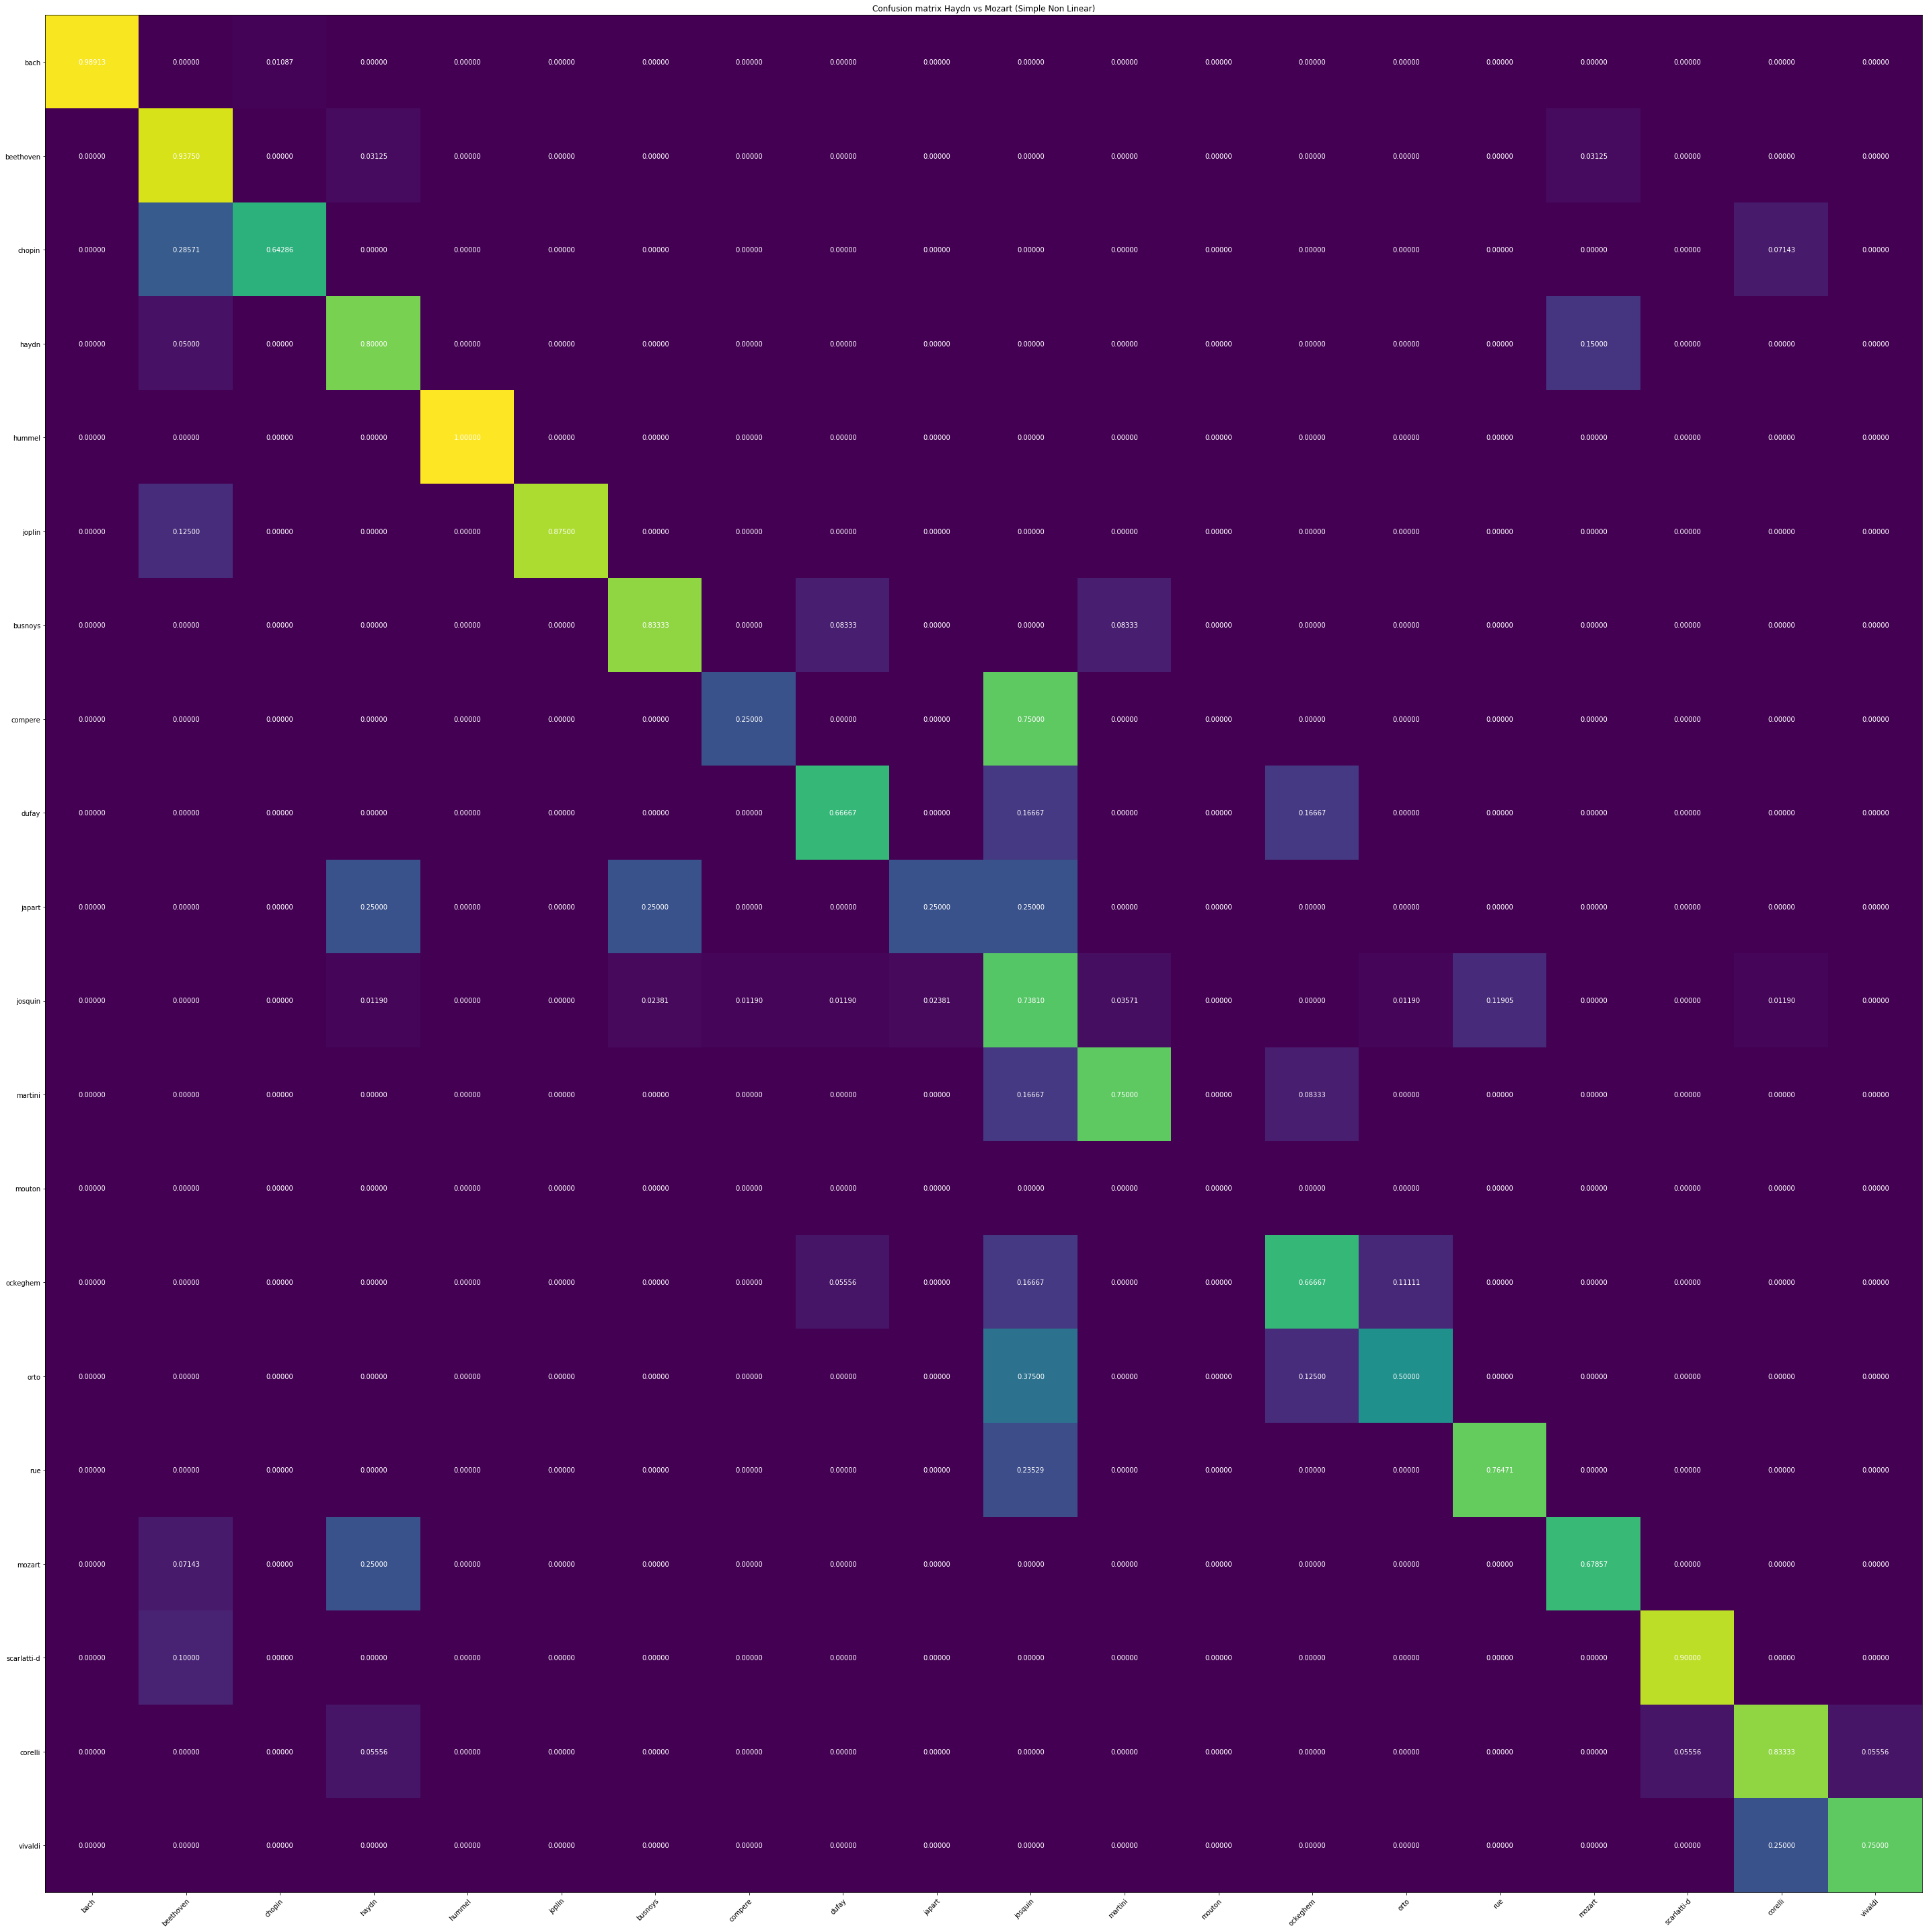

bach 46 / 46 = 1.0
beethoven 14 / 16 = 0.875
busnoys 5 / 6 = 0.8333333333333334
chopin 6 / 7 = 0.8571428571428571
compere 1 / 2 = 0.5
corelli 13 / 18 = 0.7222222222222222
dufay 2 / 3 = 0.6666666666666666
haydn 17 / 20 = 0.85
hummel 2 / 2 = 1.0
japart 1 / 2 = 0.5
joplin 4 / 4 = 1.0
josquin 37 / 42 = 0.8809523809523809
martini 9 / 12 = 0.75
mozart 9 / 14 = 0.6428571428571429
ockeghem 7 / 9 = 0.7777777777777778
orto 2 / 4 = 0.5
rue 13 / 17 = 0.7647058823529411
scarlatti-d 4 / 5 = 0.8
vivaldi 1 / 2 = 0.5
193 231 0.8354978354978355
---------------------------------------------
---------------------------------------------
Fold 2
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 20]) (10240)
wnotesm 

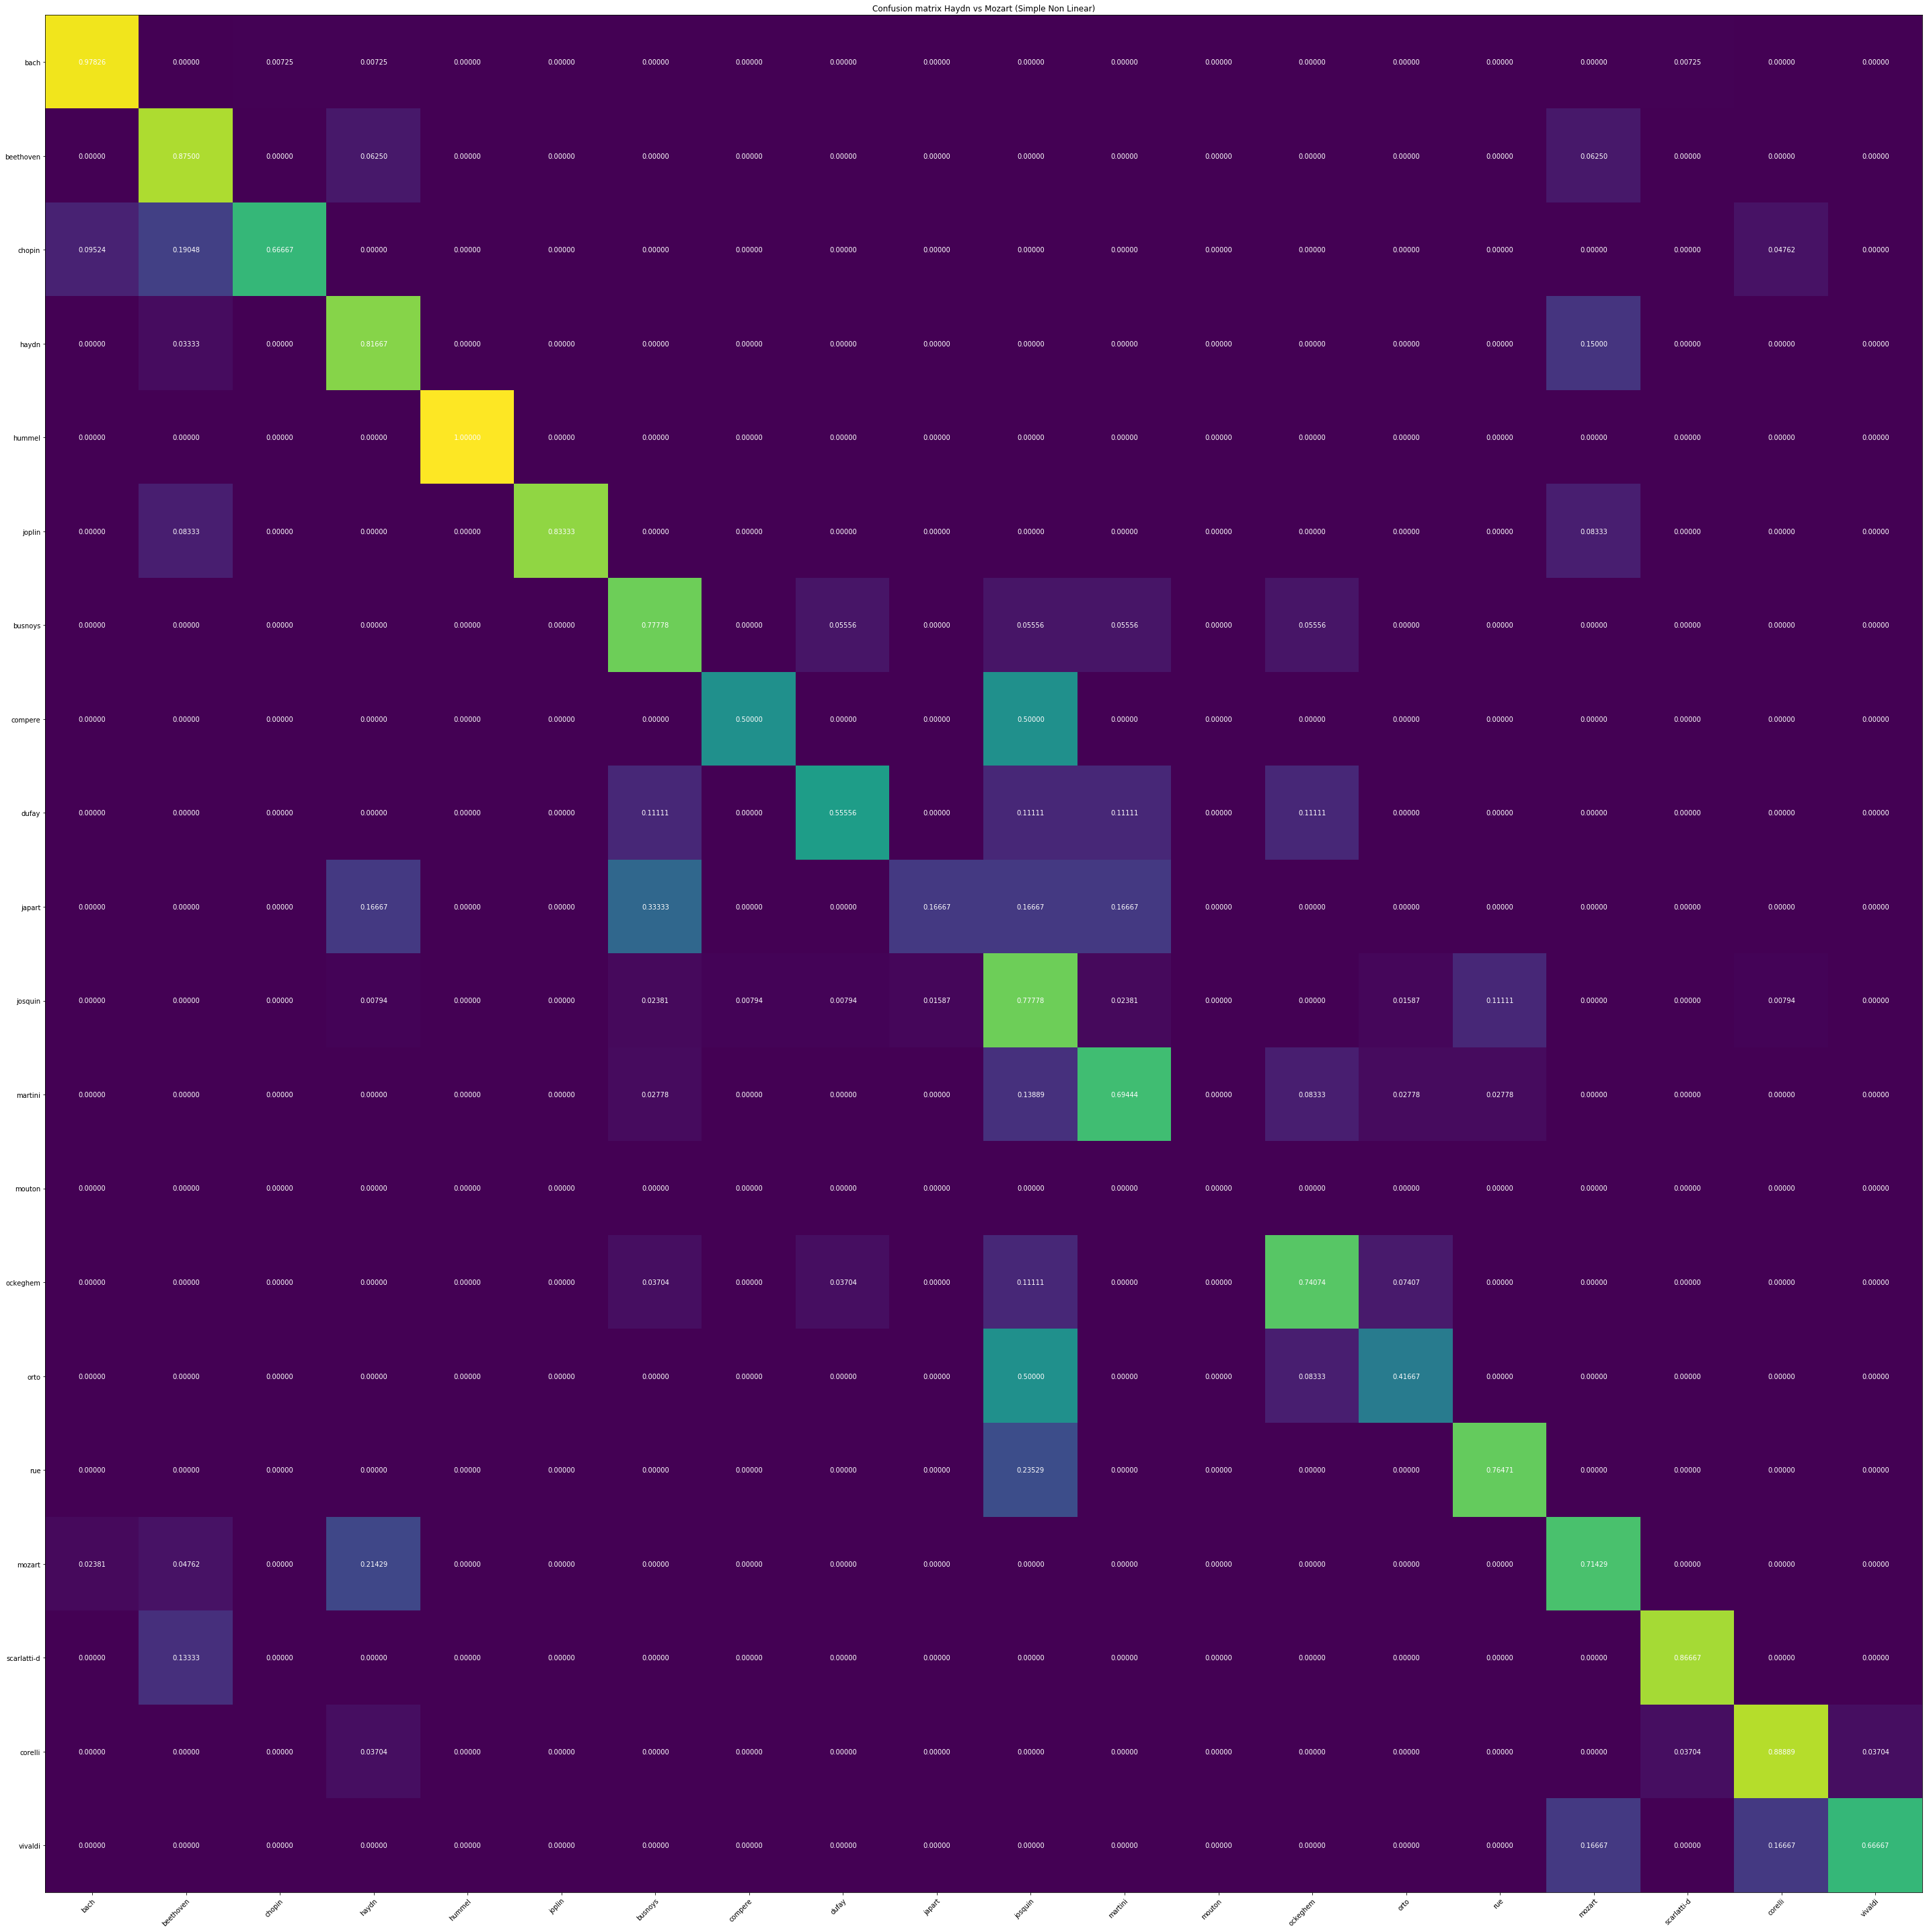

bach 44 / 46 = 0.9565217391304348
beethoven 12 / 16 = 0.75
busnoys 4 / 6 = 0.6666666666666666
chopin 5 / 7 = 0.7142857142857143
compere 2 / 2 = 1.0
corelli 18 / 18 = 1.0
dufay 1 / 3 = 0.3333333333333333
haydn 17 / 20 = 0.85
hummel 2 / 2 = 1.0
japart 0 / 2 = 0.0
joplin 3 / 4 = 0.75
josquin 36 / 42 = 0.8571428571428571
martini 7 / 12 = 0.5833333333333334
mozart 11 / 14 = 0.7857142857142857
ockeghem 8 / 9 = 0.8888888888888888
orto 1 / 4 = 0.25
rue 13 / 17 = 0.7647058823529411
scarlatti-d 4 / 5 = 0.8
vivaldi 1 / 2 = 0.5
189 231 0.8181818181818182
---------------------------------------------
---------------------------------------------
Fold 3
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 20]) 

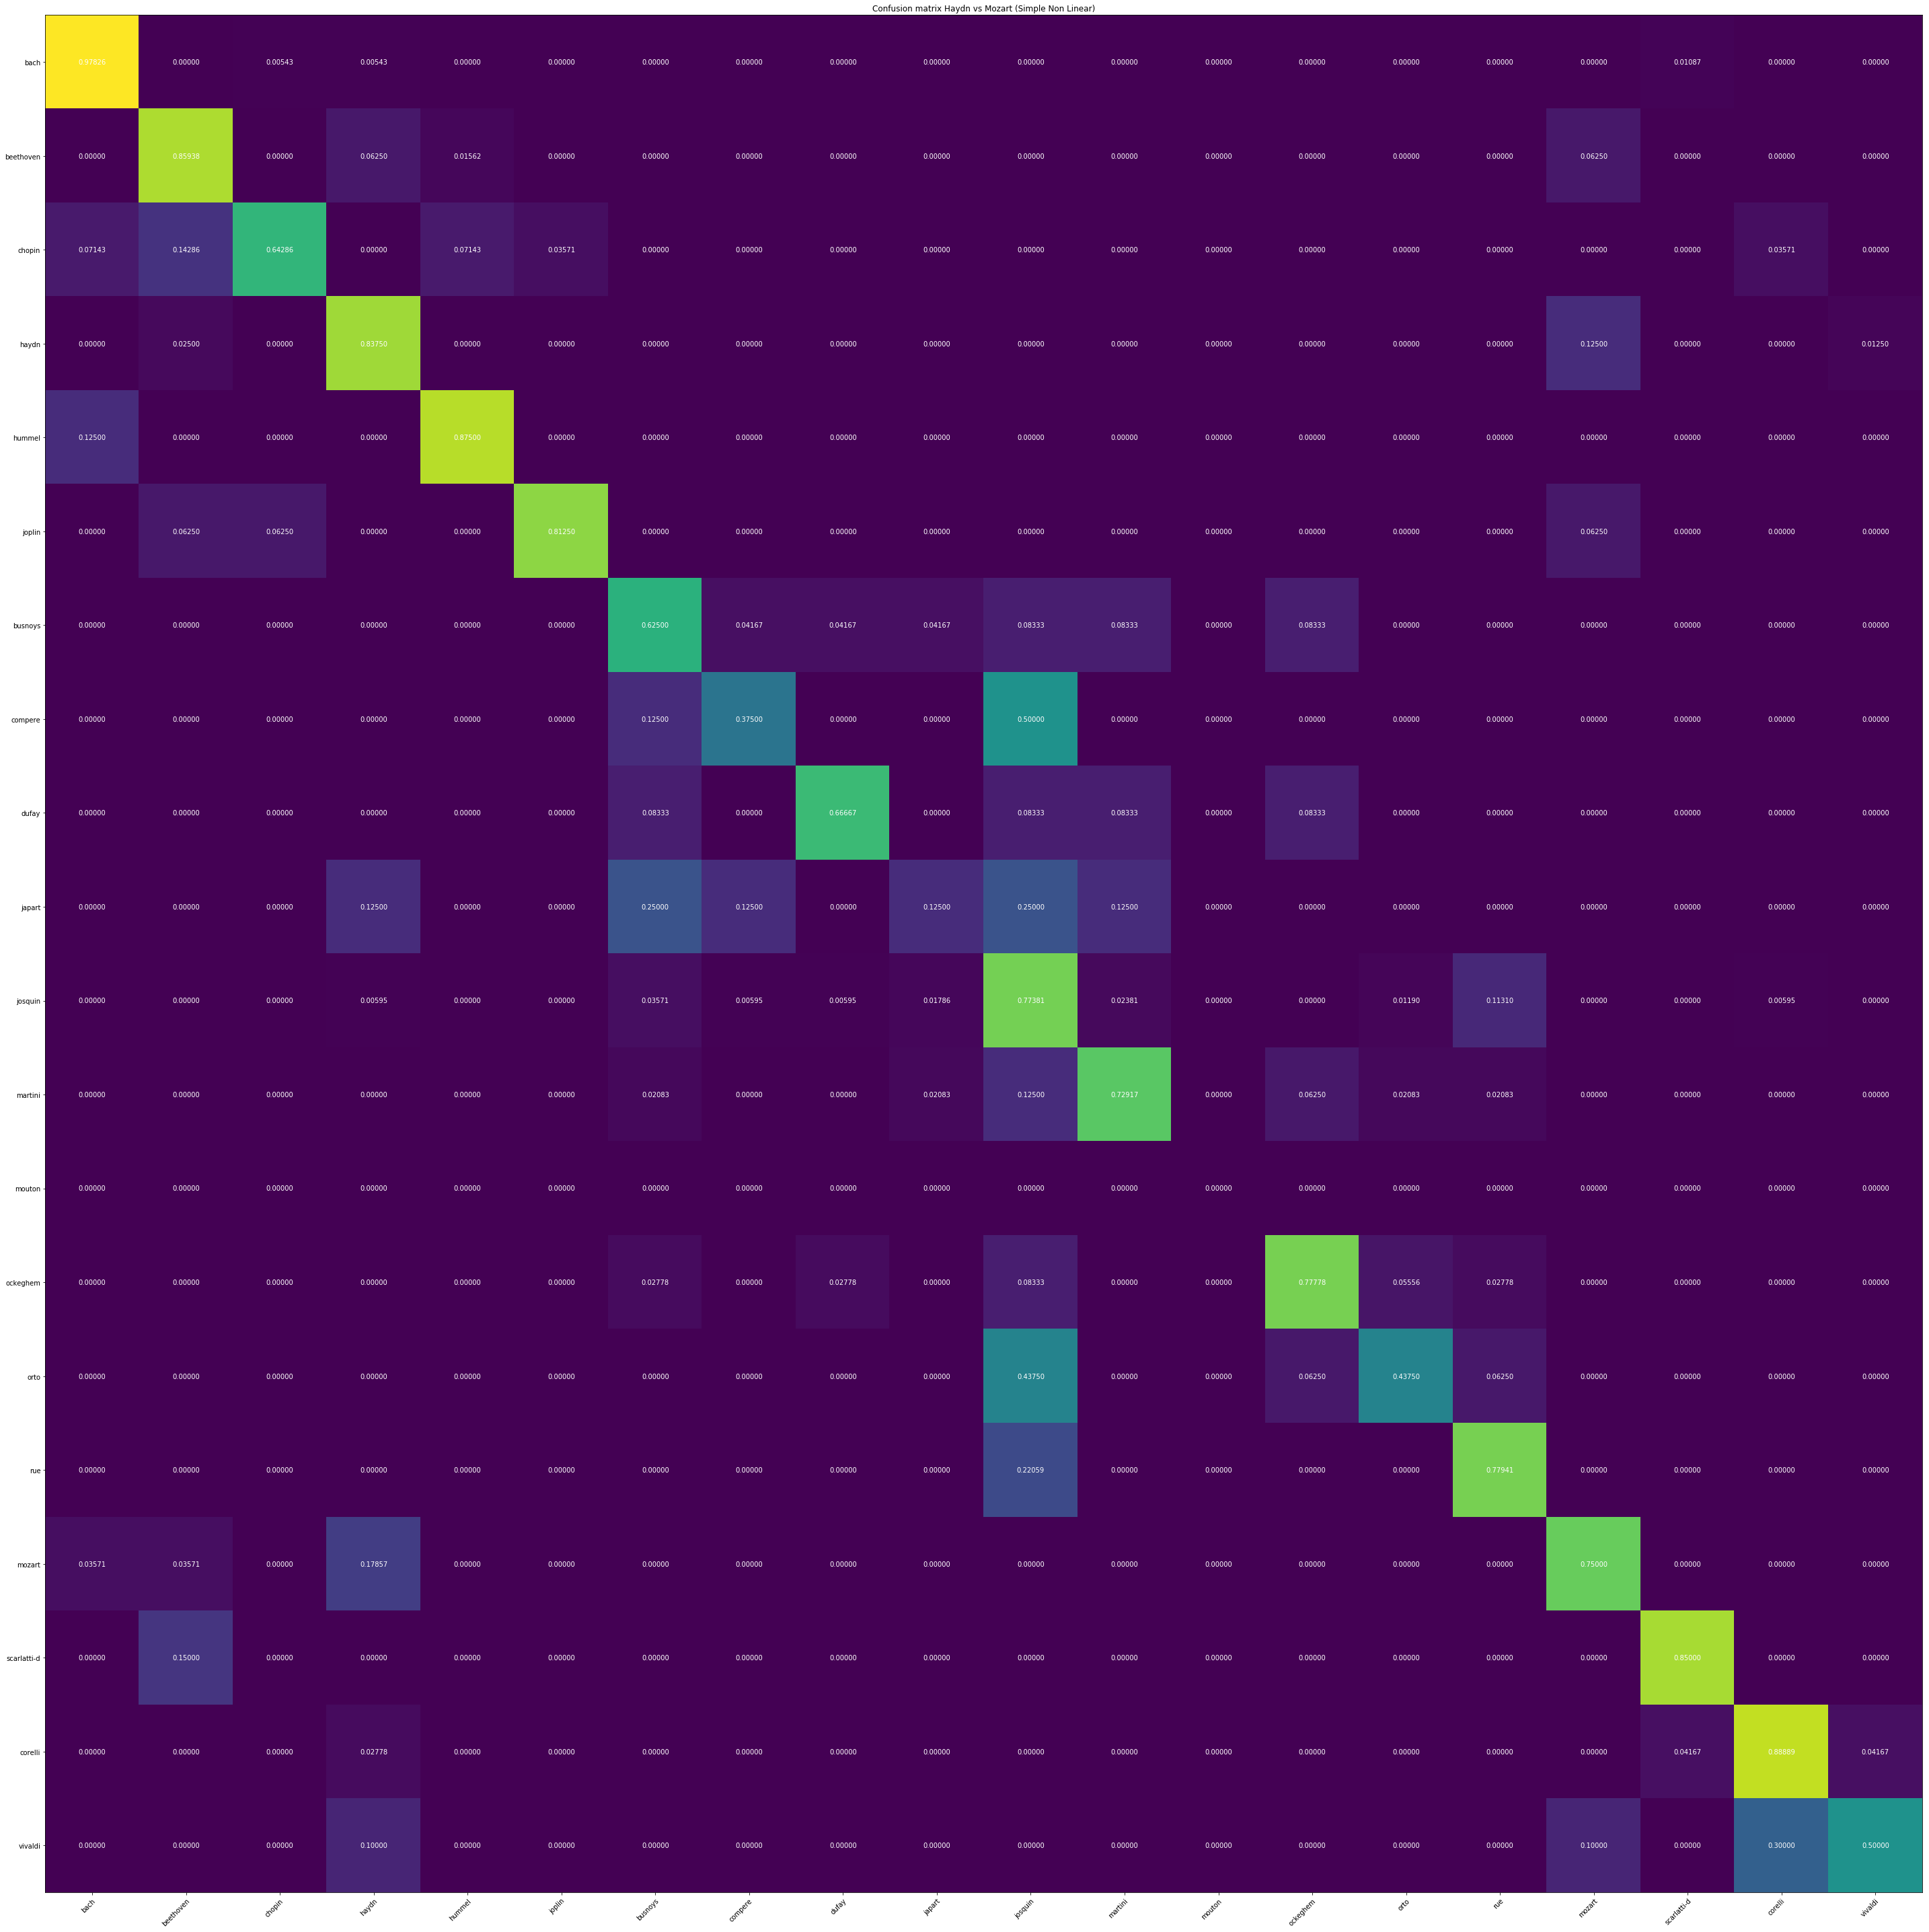

bach 45 / 46 = 0.9782608695652174
beethoven 13 / 16 = 0.8125
busnoys 1 / 6 = 0.16666666666666666
chopin 4 / 7 = 0.5714285714285714
compere 0 / 2 = 0.0
corelli 16 / 18 = 0.8888888888888888
dufay 3 / 3 = 1.0
haydn 18 / 20 = 0.9
hummel 1 / 2 = 0.5
japart 0 / 2 = 0.0
joplin 3 / 4 = 0.75
josquin 32 / 42 = 0.7619047619047619
martini 10 / 12 = 0.8333333333333334
mozart 12 / 14 = 0.8571428571428571
ockeghem 8 / 9 = 0.8888888888888888
orto 2 / 4 = 0.5
rue 14 / 17 = 0.8235294117647058
scarlatti-d 4 / 5 = 0.8
vivaldi 1 / 4 = 0.25
187 233 0.8025751072961373
---------------------------------------------
---------------------------------------------
Fold 4
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 20

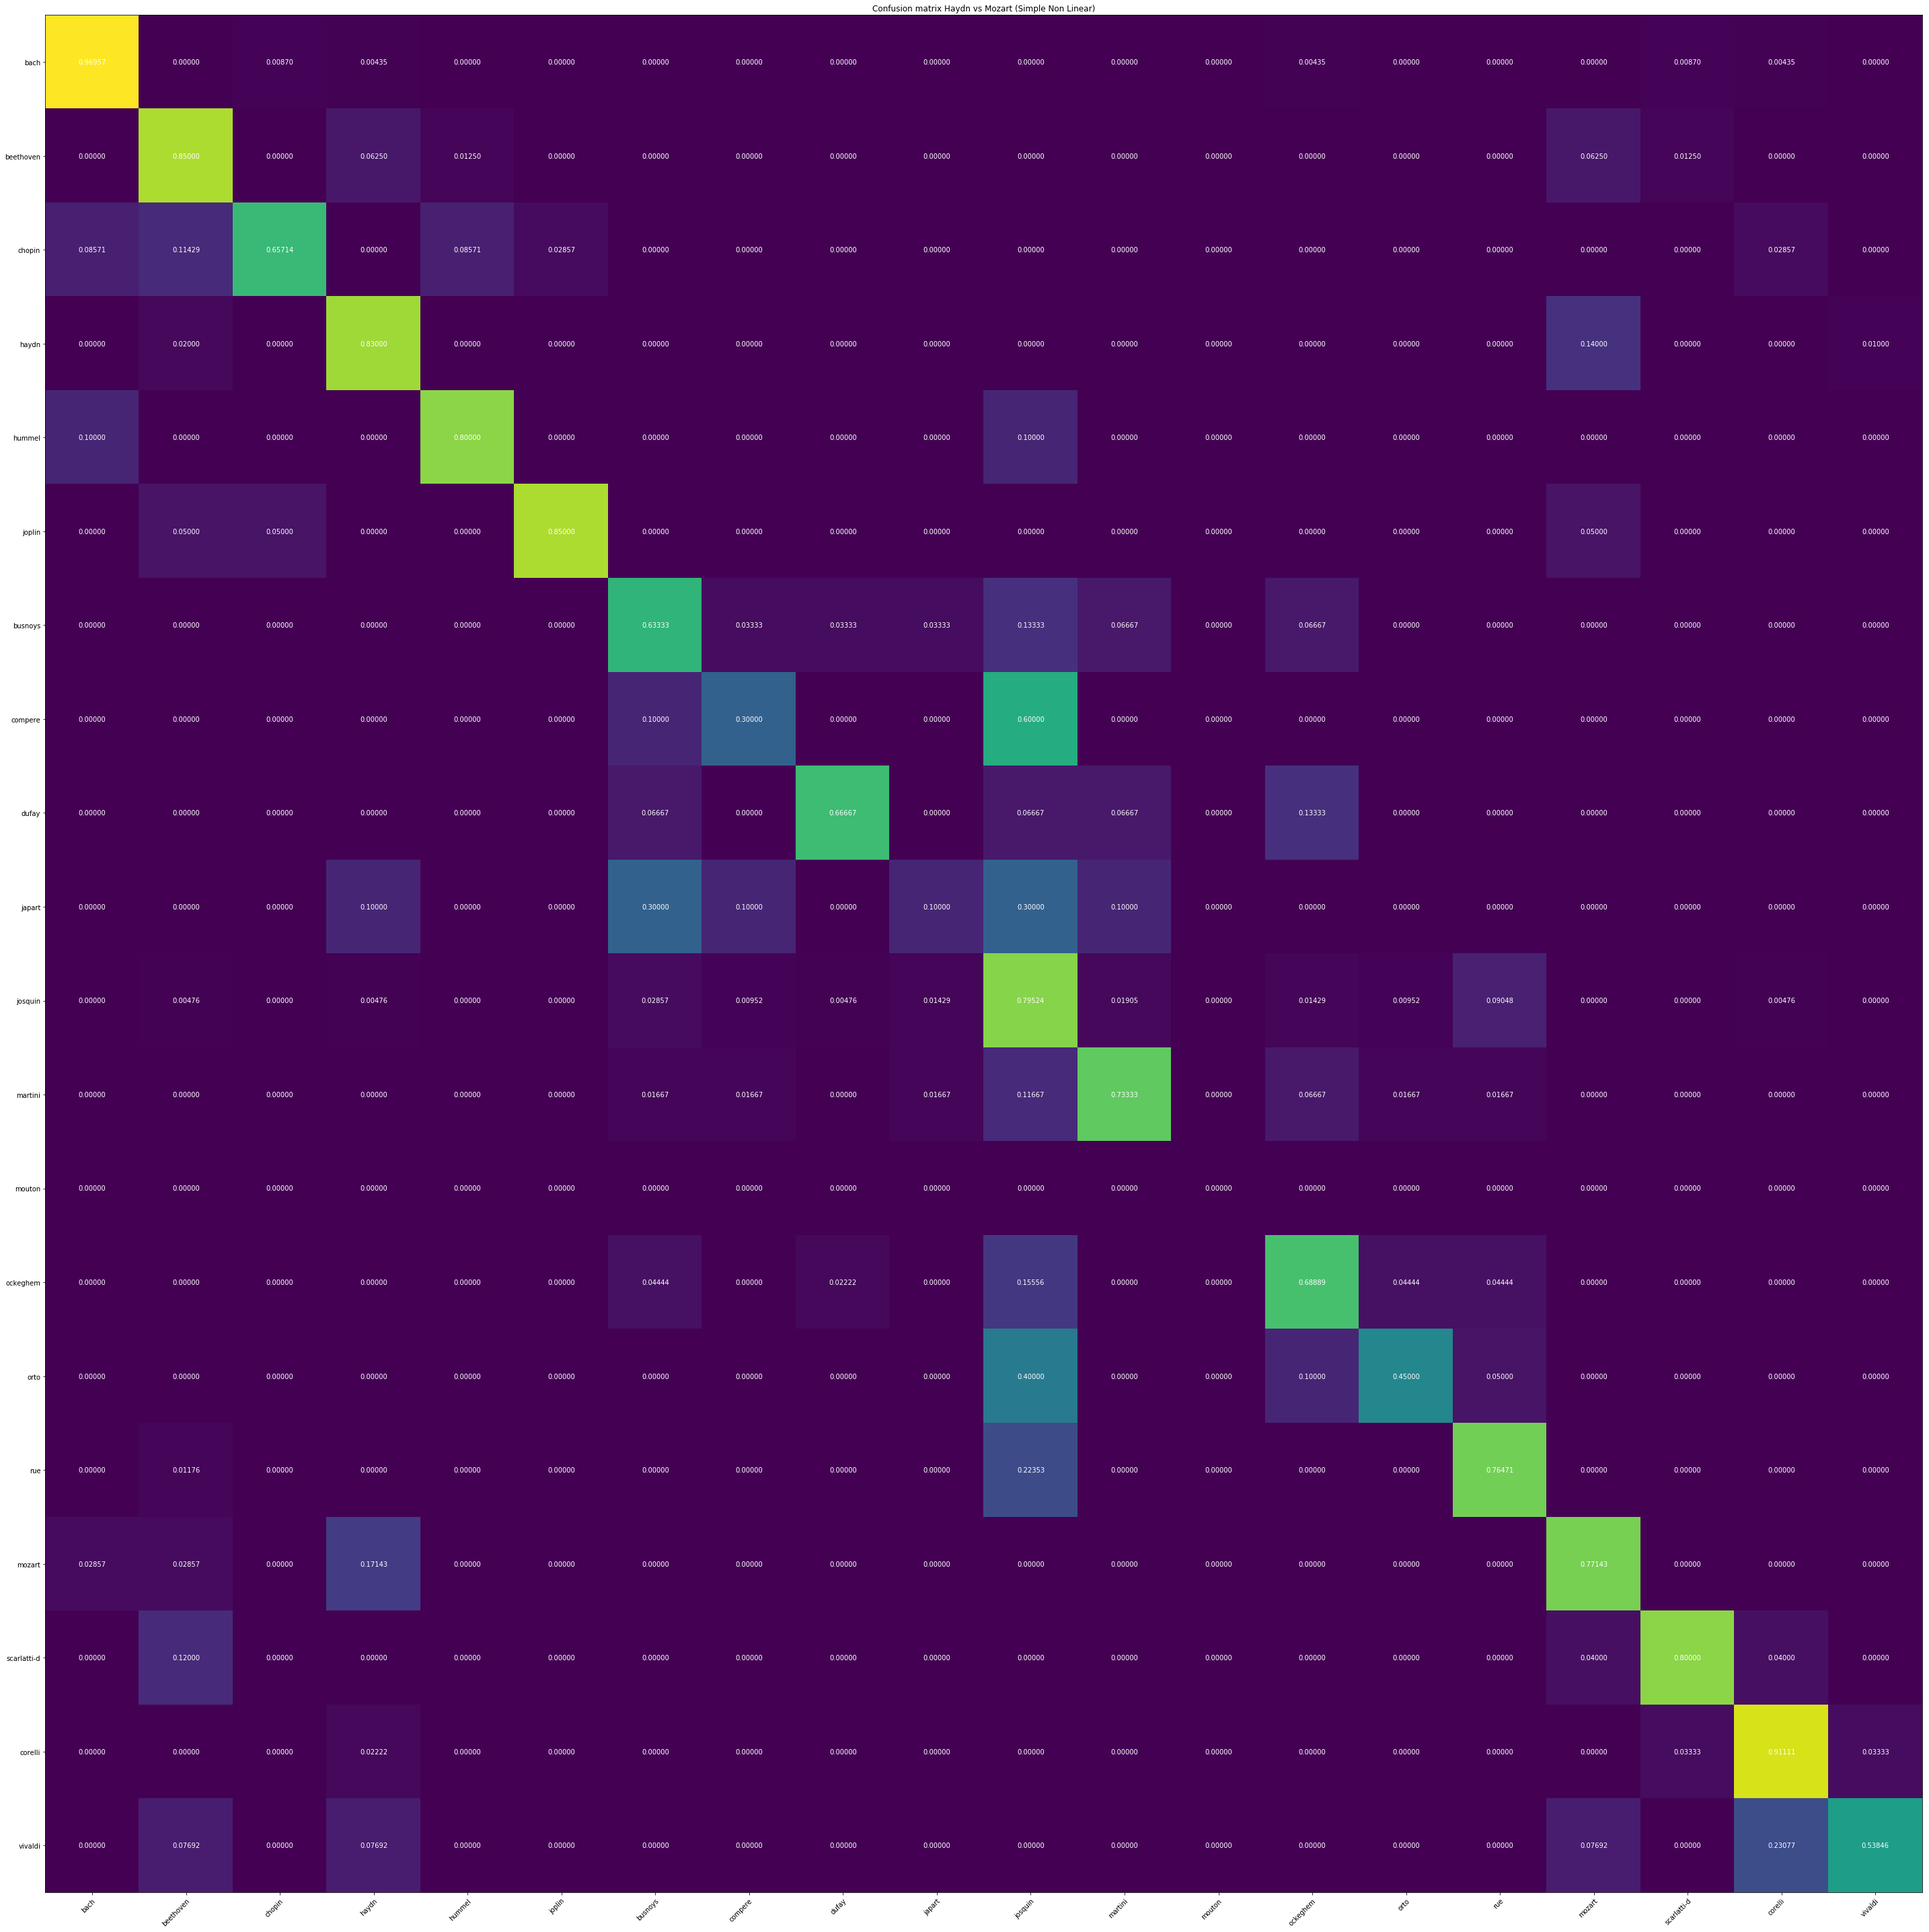

bach 43 / 46 = 0.9347826086956522
beethoven 13 / 16 = 0.8125
busnoys 4 / 6 = 0.6666666666666666
chopin 5 / 7 = 0.7142857142857143
compere 0 / 2 = 0.0
corelli 18 / 18 = 1.0
dufay 2 / 3 = 0.6666666666666666
haydn 16 / 20 = 0.8
hummel 1 / 2 = 0.5
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 37 / 42 = 0.8809523809523809
martini 9 / 12 = 0.75
mozart 12 / 14 = 0.8571428571428571
ockeghem 3 / 9 = 0.3333333333333333
orto 2 / 4 = 0.5
rue 12 / 17 = 0.7058823529411765
scarlatti-d 3 / 5 = 0.6
vivaldi 2 / 3 = 0.6666666666666666
186 232 0.8017241379310345
---------------------------------------------
---------------------------------------------
Fold 5
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 20]) 

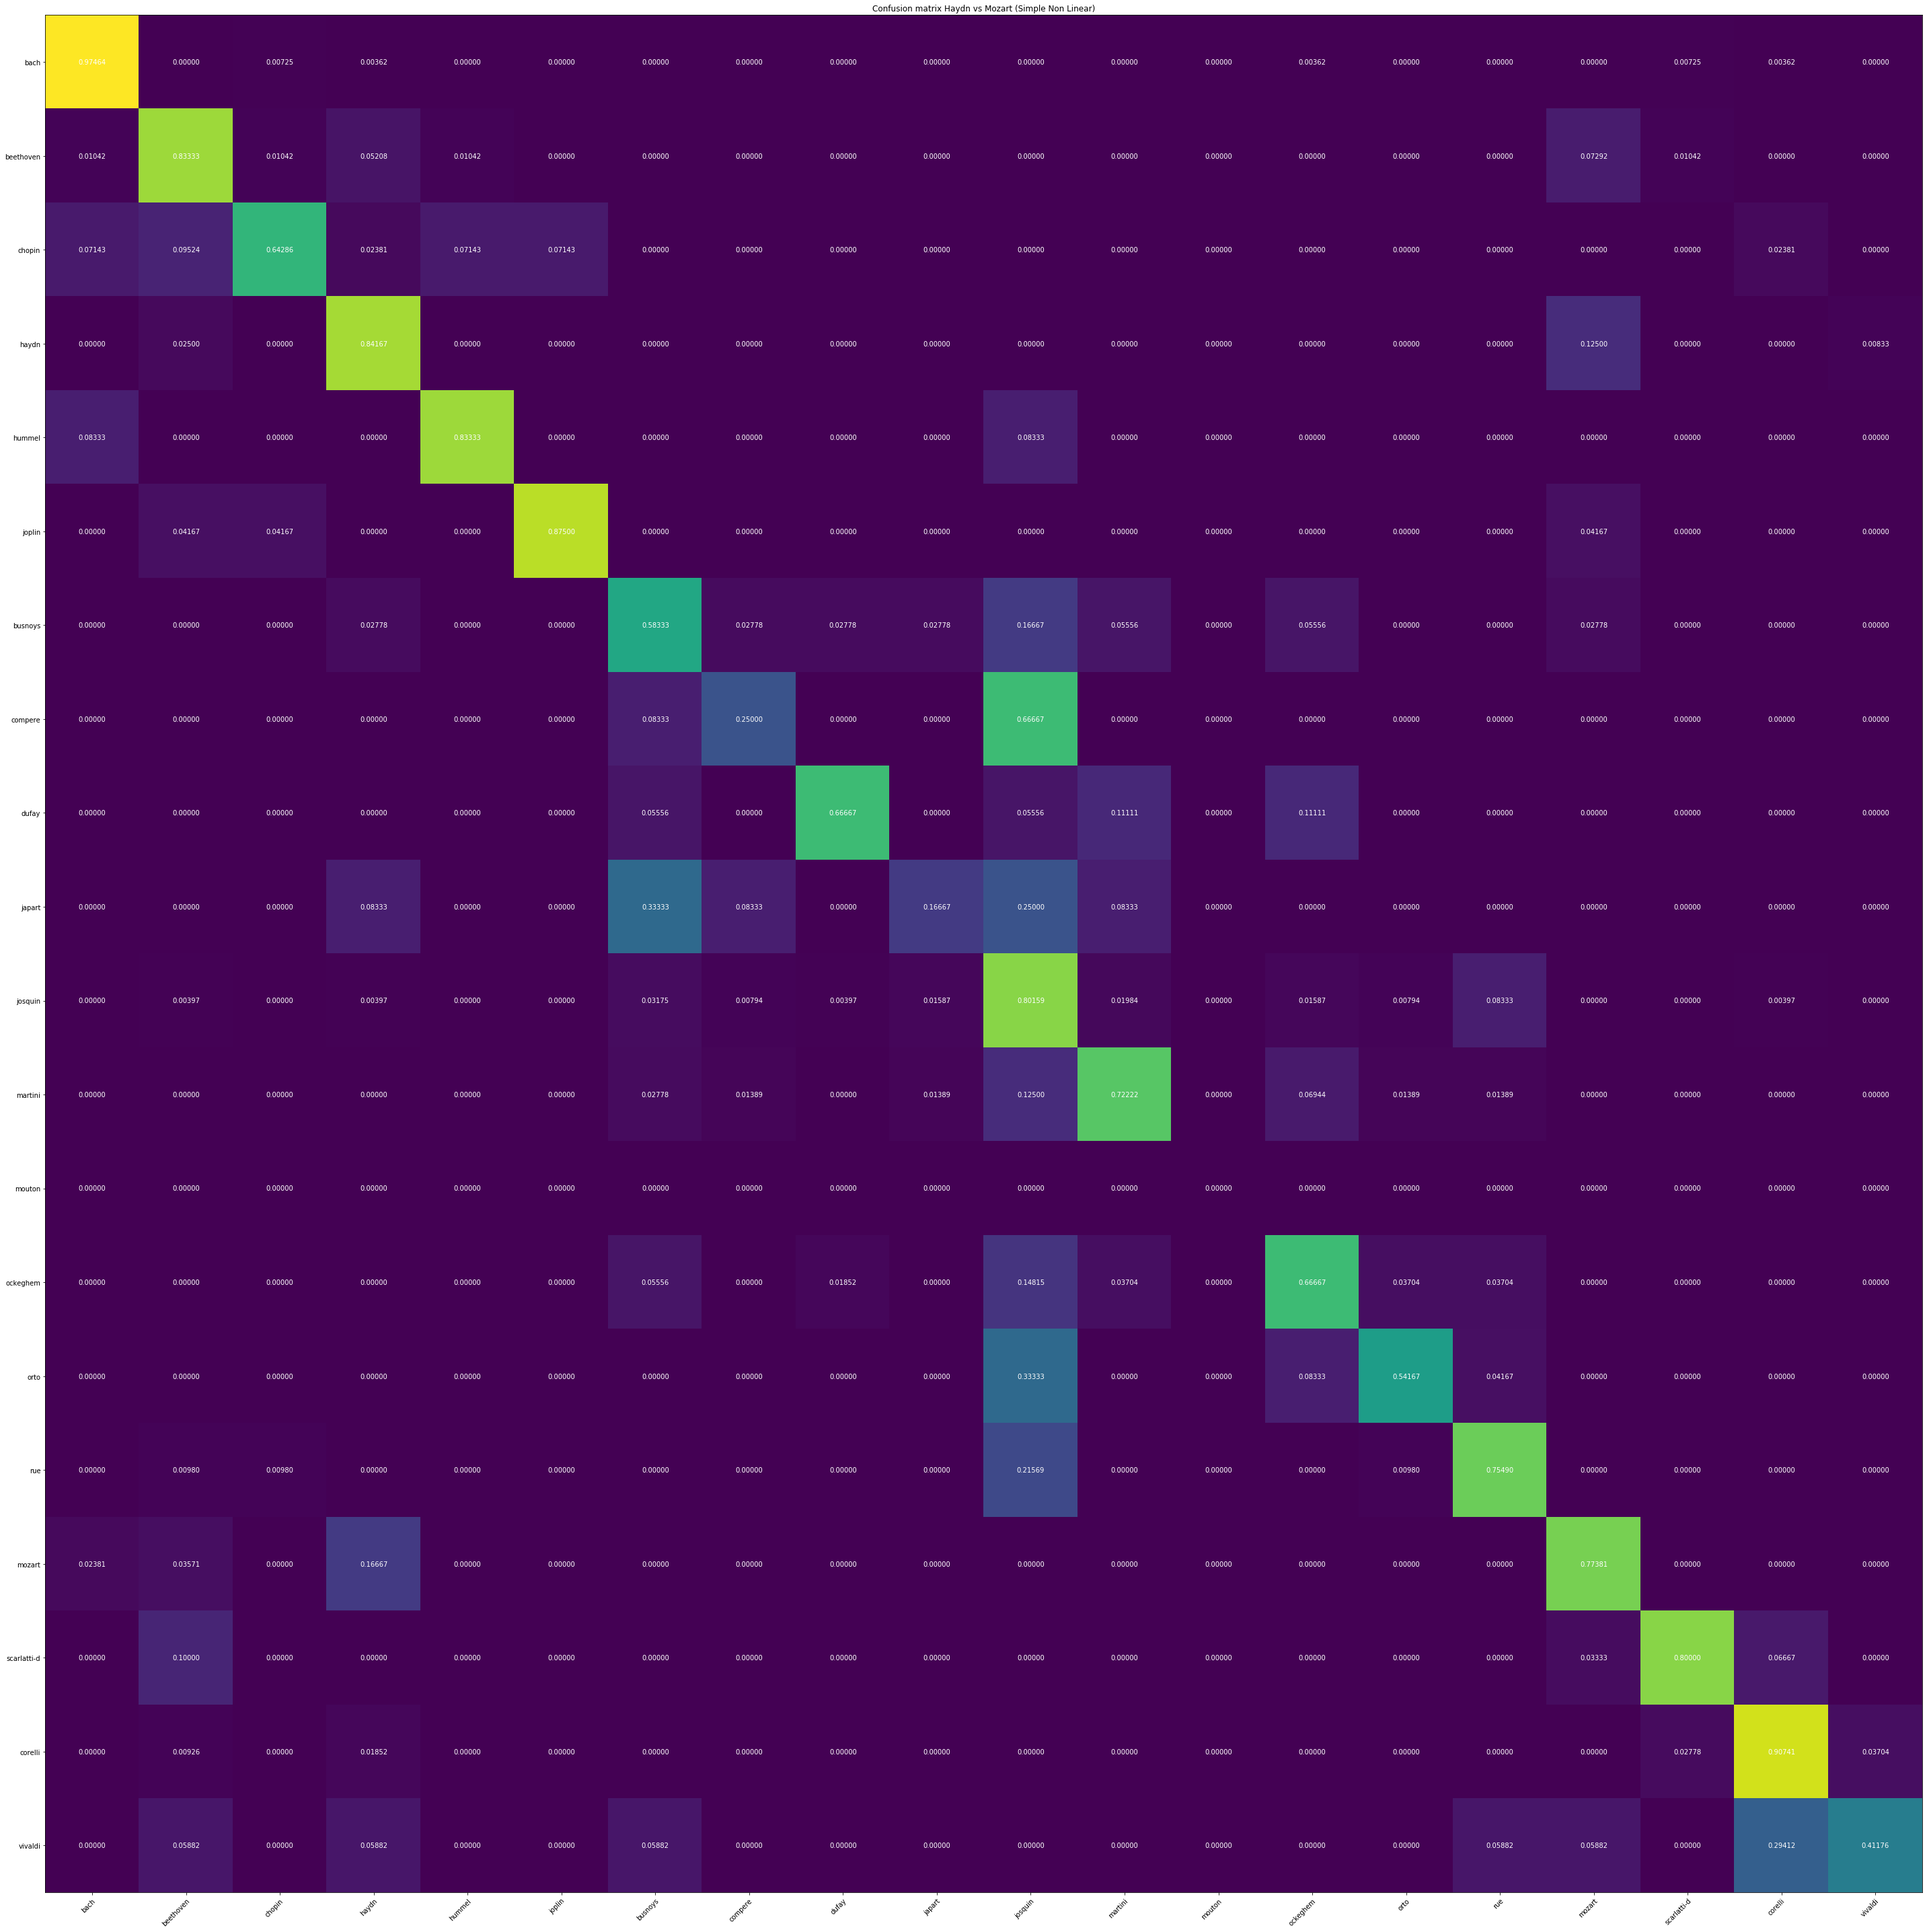

bach 46 / 46 = 1.0
beethoven 12 / 16 = 0.75
busnoys 2 / 6 = 0.3333333333333333
chopin 4 / 7 = 0.5714285714285714
compere 0 / 2 = 0.0
corelli 16 / 18 = 0.8888888888888888
dufay 2 / 3 = 0.6666666666666666
haydn 18 / 20 = 0.9
hummel 2 / 2 = 1.0
japart 1 / 2 = 0.5
joplin 4 / 4 = 1.0
josquin 35 / 42 = 0.8333333333333334
martini 8 / 12 = 0.6666666666666666
mozart 11 / 14 = 0.7857142857142857
ockeghem 5 / 9 = 0.5555555555555556
orto 4 / 4 = 1.0
rue 12 / 17 = 0.7058823529411765
scarlatti-d 4 / 5 = 0.8
vivaldi 0 / 4 = 0.0
186 233 0.7982832618025751
---------------------------------------------
---------------------------------------------
Fold 6
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 20]) (10

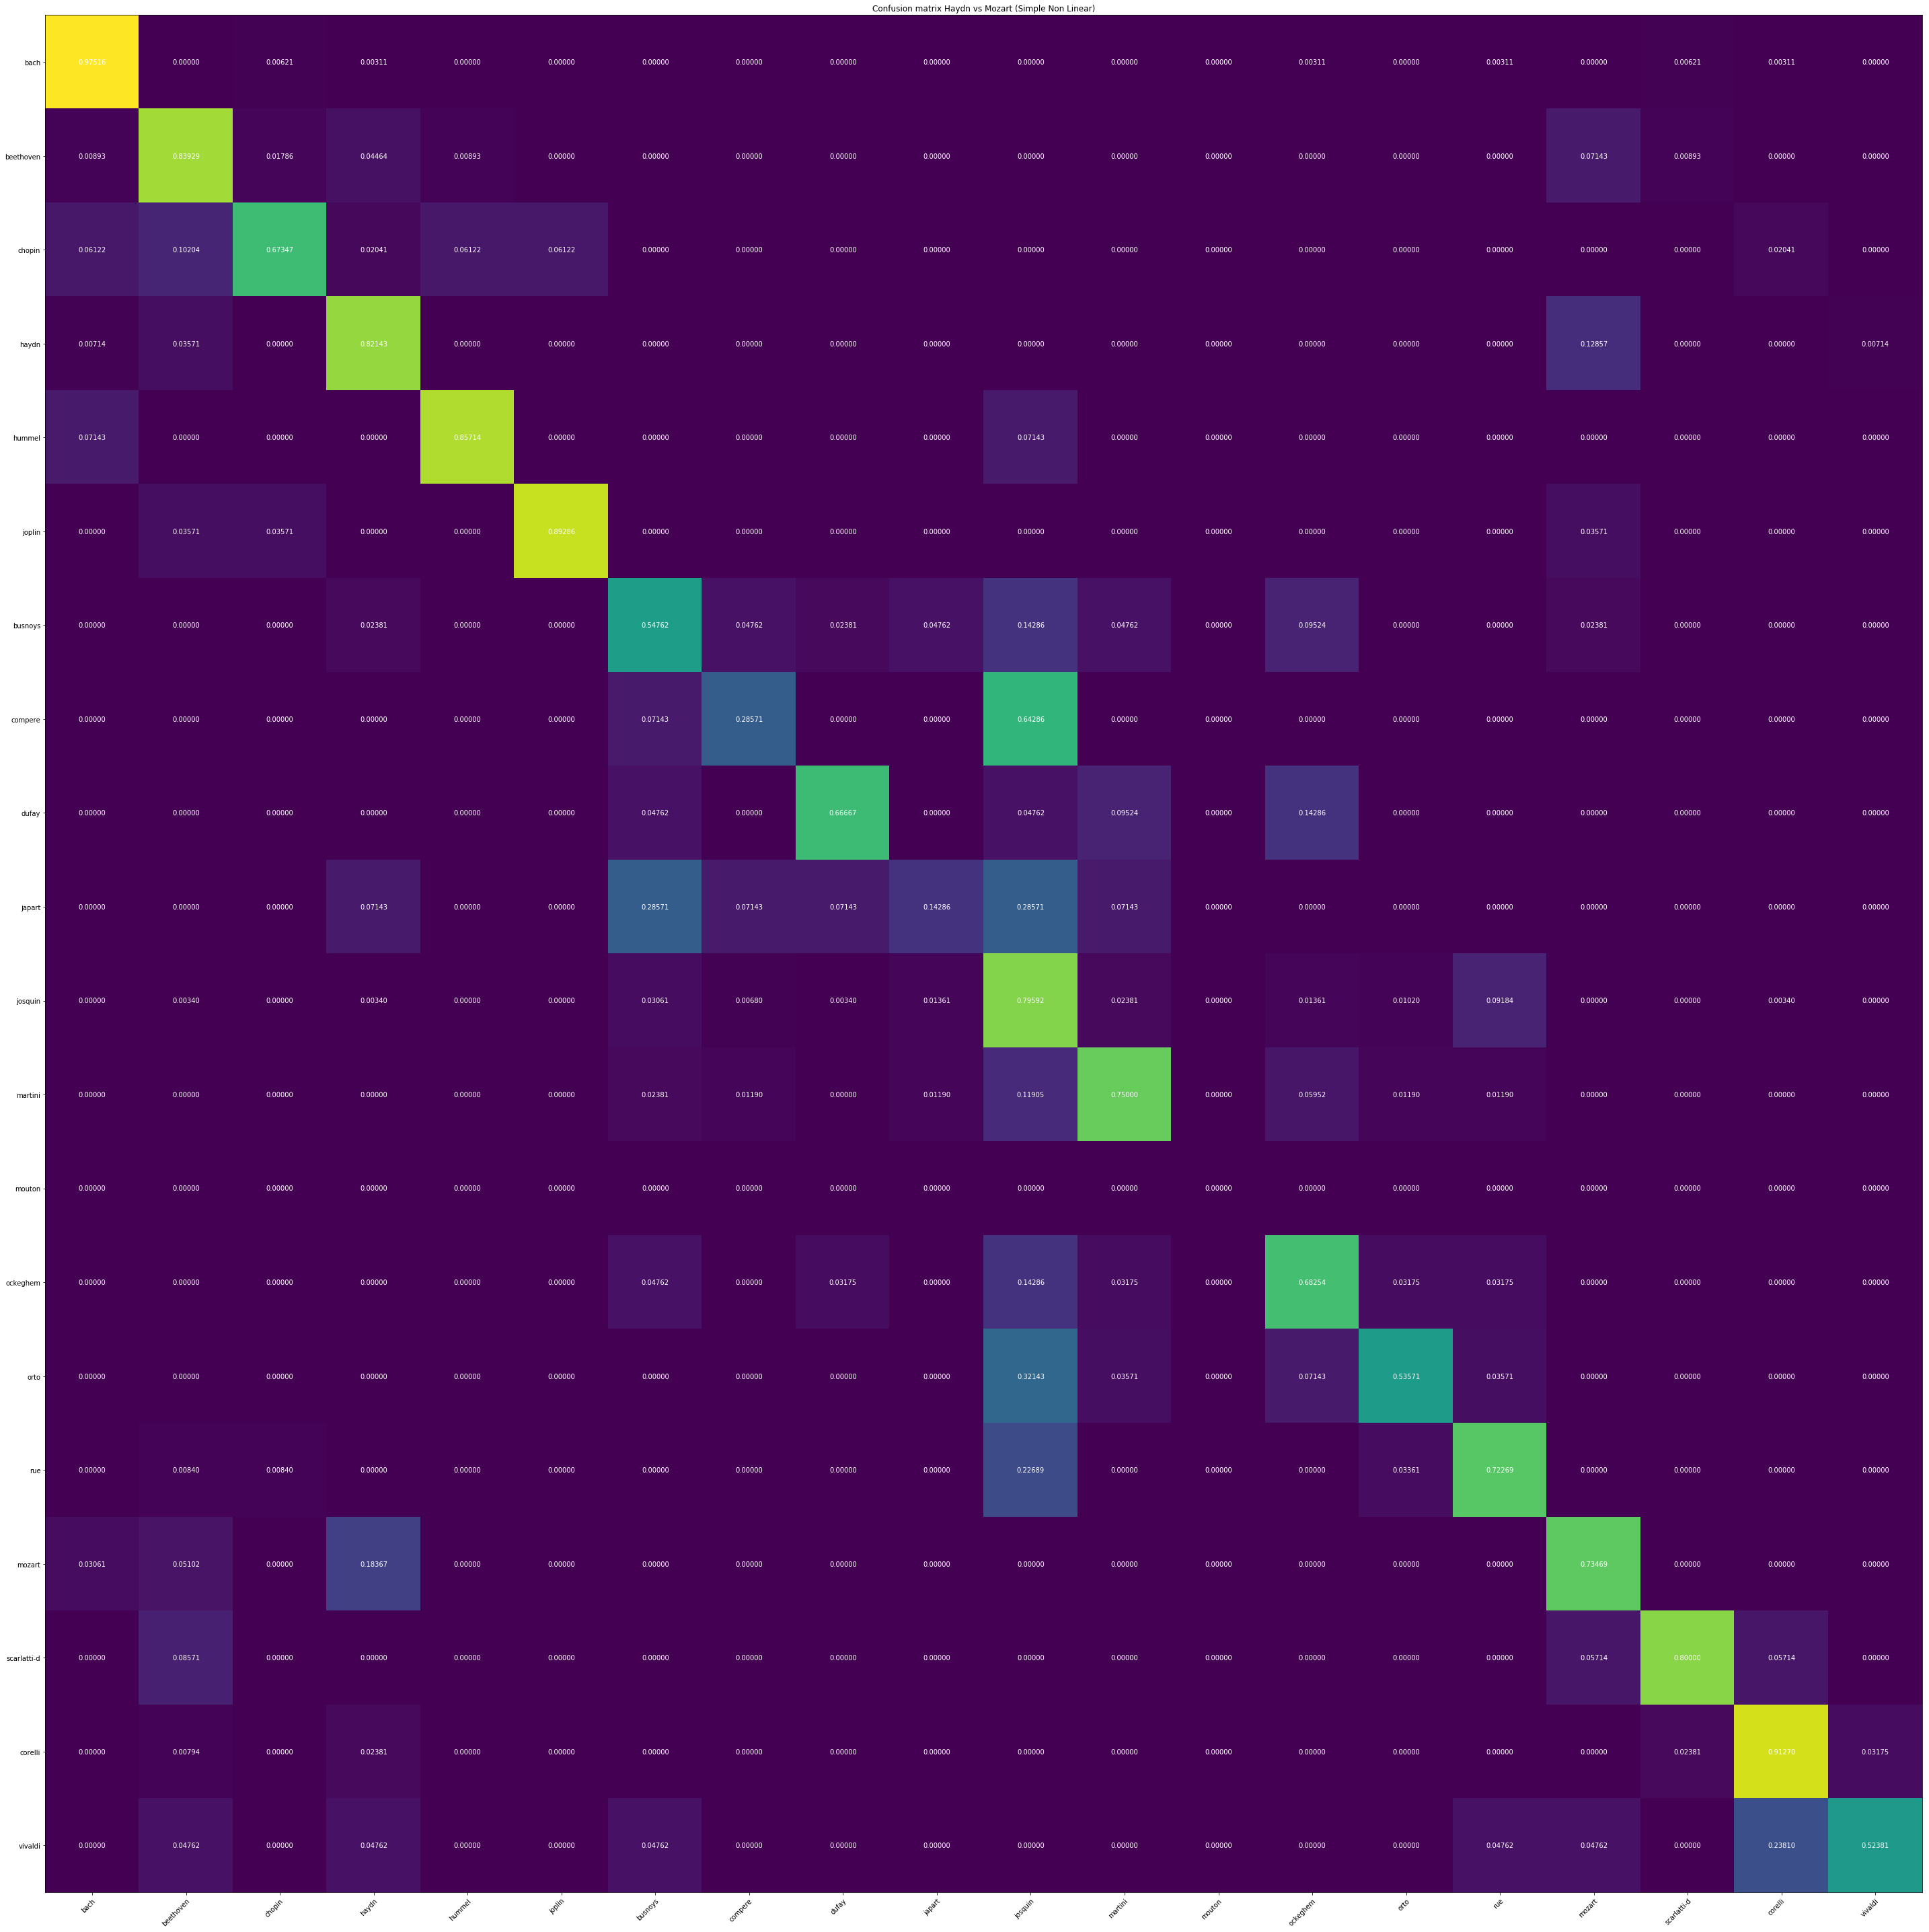

bach 45 / 46 = 0.9782608695652174
beethoven 14 / 16 = 0.875
busnoys 2 / 6 = 0.3333333333333333
chopin 6 / 7 = 0.8571428571428571
compere 1 / 2 = 0.5
corelli 17 / 18 = 0.9444444444444444
dufay 2 / 3 = 0.6666666666666666
haydn 14 / 20 = 0.7
hummel 2 / 2 = 1.0
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 32 / 42 = 0.7619047619047619
martini 11 / 12 = 0.9166666666666666
mozart 7 / 14 = 0.5
ockeghem 7 / 9 = 0.7777777777777778
orto 2 / 4 = 0.5
rue 9 / 17 = 0.5294117647058824
scarlatti-d 4 / 5 = 0.8
vivaldi 4 / 4 = 1.0
183 233 0.7854077253218884
---------------------------------------------
---------------------------------------------
Fold 7
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 20]) (10

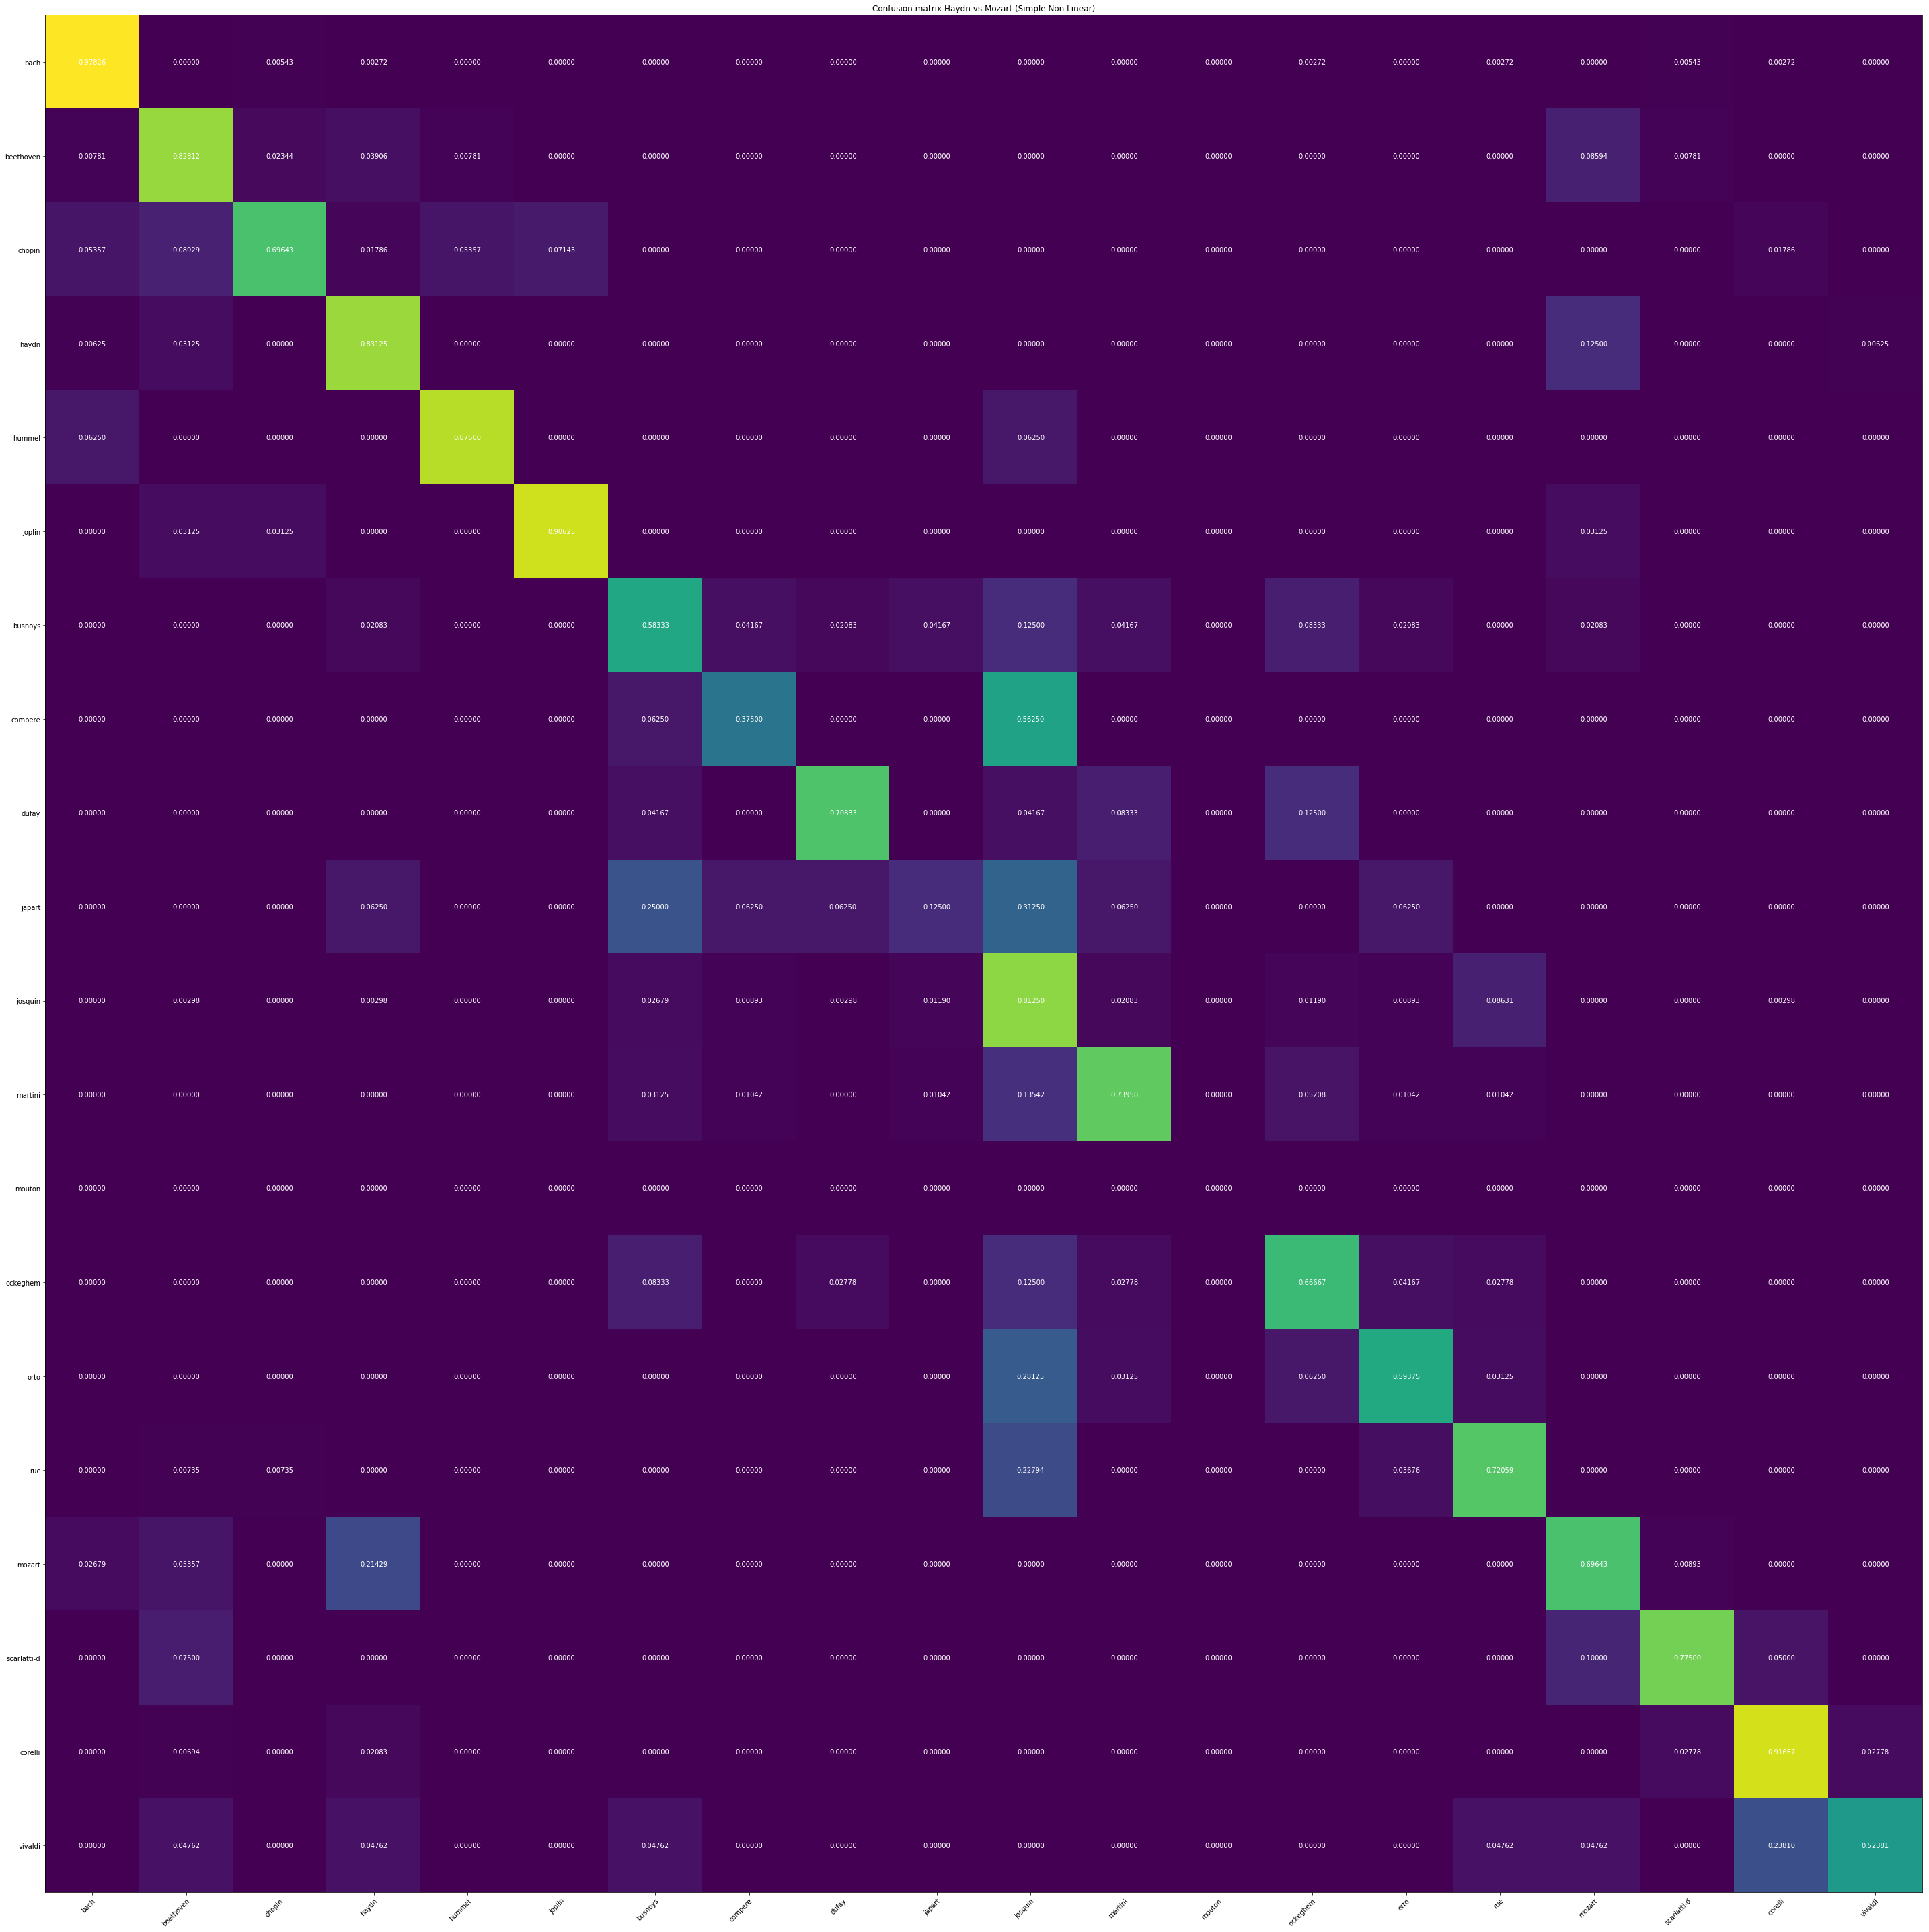

bach 46 / 46 = 1.0
beethoven 12 / 16 = 0.75
busnoys 5 / 6 = 0.8333333333333334
chopin 6 / 7 = 0.8571428571428571
compere 2 / 2 = 1.0
corelli 17 / 18 = 0.9444444444444444
dufay 3 / 3 = 1.0
haydn 18 / 20 = 0.9
hummel 2 / 2 = 1.0
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 39 / 42 = 0.9285714285714286
martini 8 / 12 = 0.6666666666666666
mozart 6 / 14 = 0.42857142857142855
ockeghem 5 / 9 = 0.5555555555555556
orto 4 / 4 = 1.0
rue 12 / 17 = 0.7058823529411765
scarlatti-d 3 / 5 = 0.6
192 229 0.8384279475982532
---------------------------------------------
---------------------------------------------
Fold 8
len validation_ids 400
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 20]) (10240)
wnotesm torch.Size([256, 78, 1

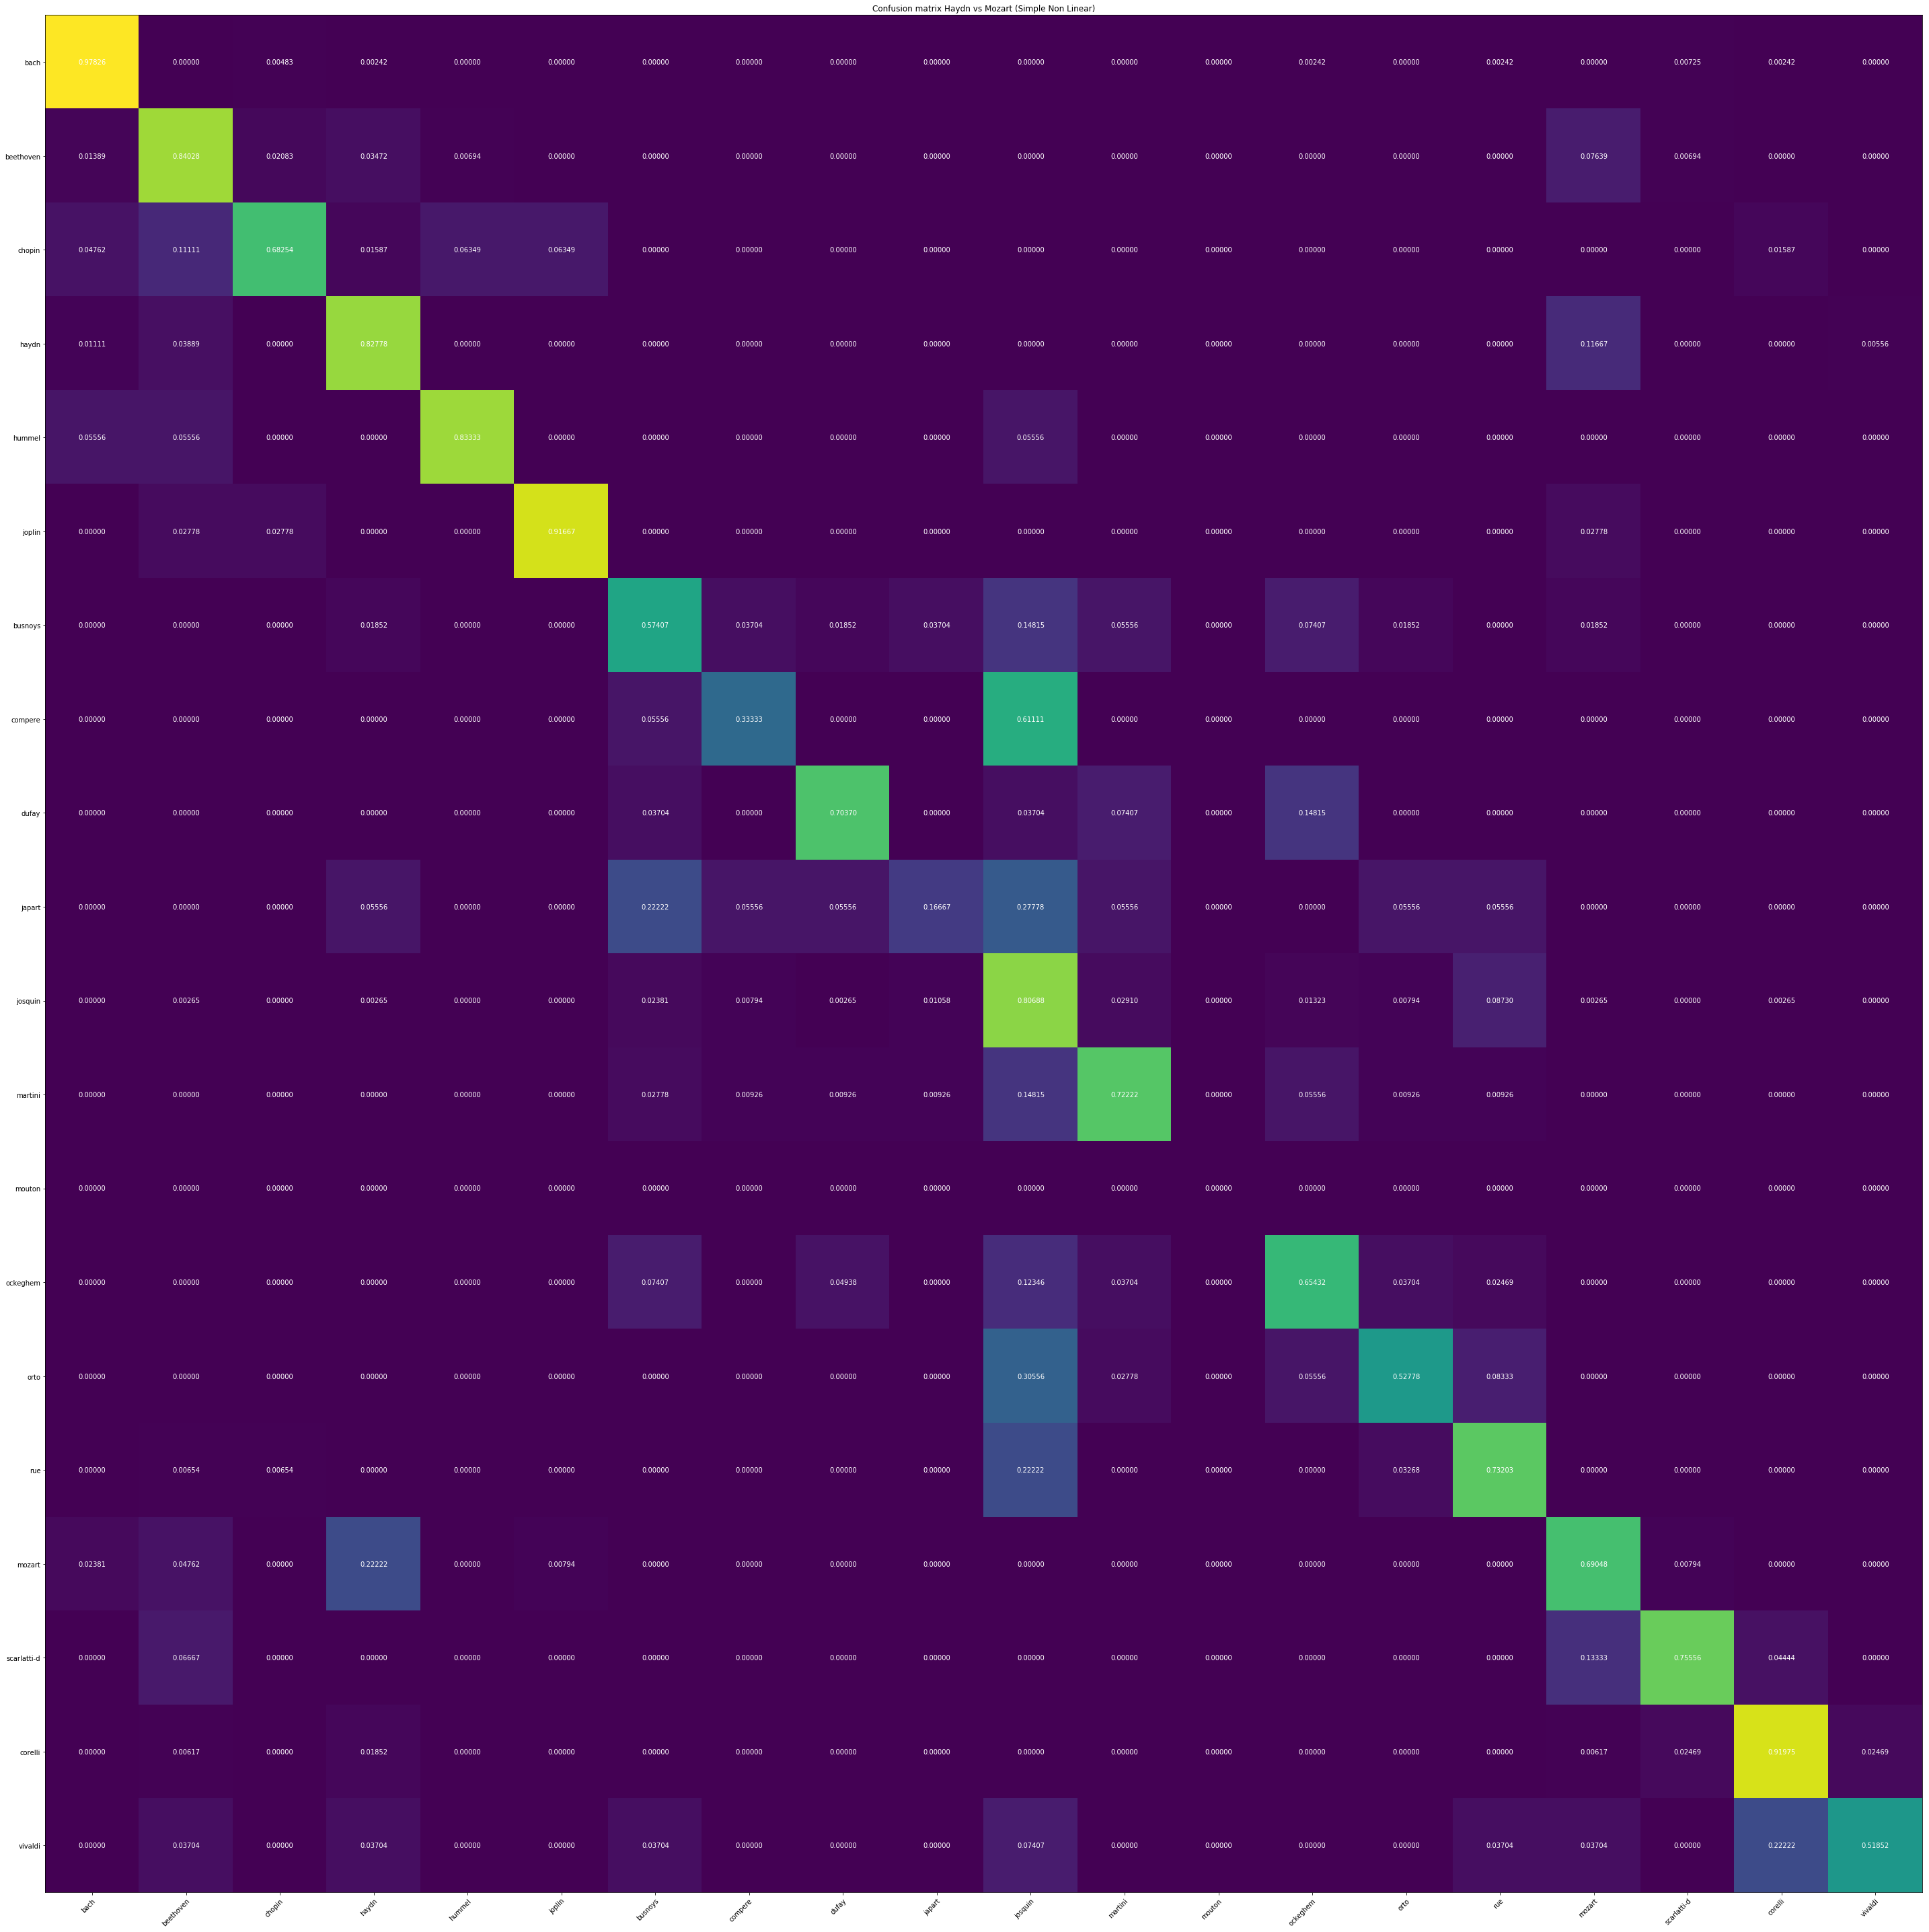

bach 45 / 46 = 0.9782608695652174
beethoven 15 / 16 = 0.9375
busnoys 3 / 6 = 0.5
chopin 4 / 7 = 0.5714285714285714
compere 0 / 2 = 0.0
corelli 17 / 18 = 0.9444444444444444
dufay 2 / 3 = 0.6666666666666666
haydn 16 / 20 = 0.8
hummel 1 / 2 = 0.5
japart 1 / 2 = 0.5
joplin 4 / 4 = 1.0
josquin 32 / 42 = 0.7619047619047619
martini 7 / 12 = 0.5833333333333334
mozart 9 / 14 = 0.6428571428571429
ockeghem 5 / 9 = 0.5555555555555556
orto 0 / 4 = 0.0
rue 14 / 17 = 0.8235294117647058
scarlatti-d 3 / 5 = 0.6
vivaldi 3 / 6 = 0.5
181 235 0.7702127659574468
---------------------------------------------
---------------------------------------------
Fold 9
len validation_ids 246
len test_ids 400
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 20]) (1

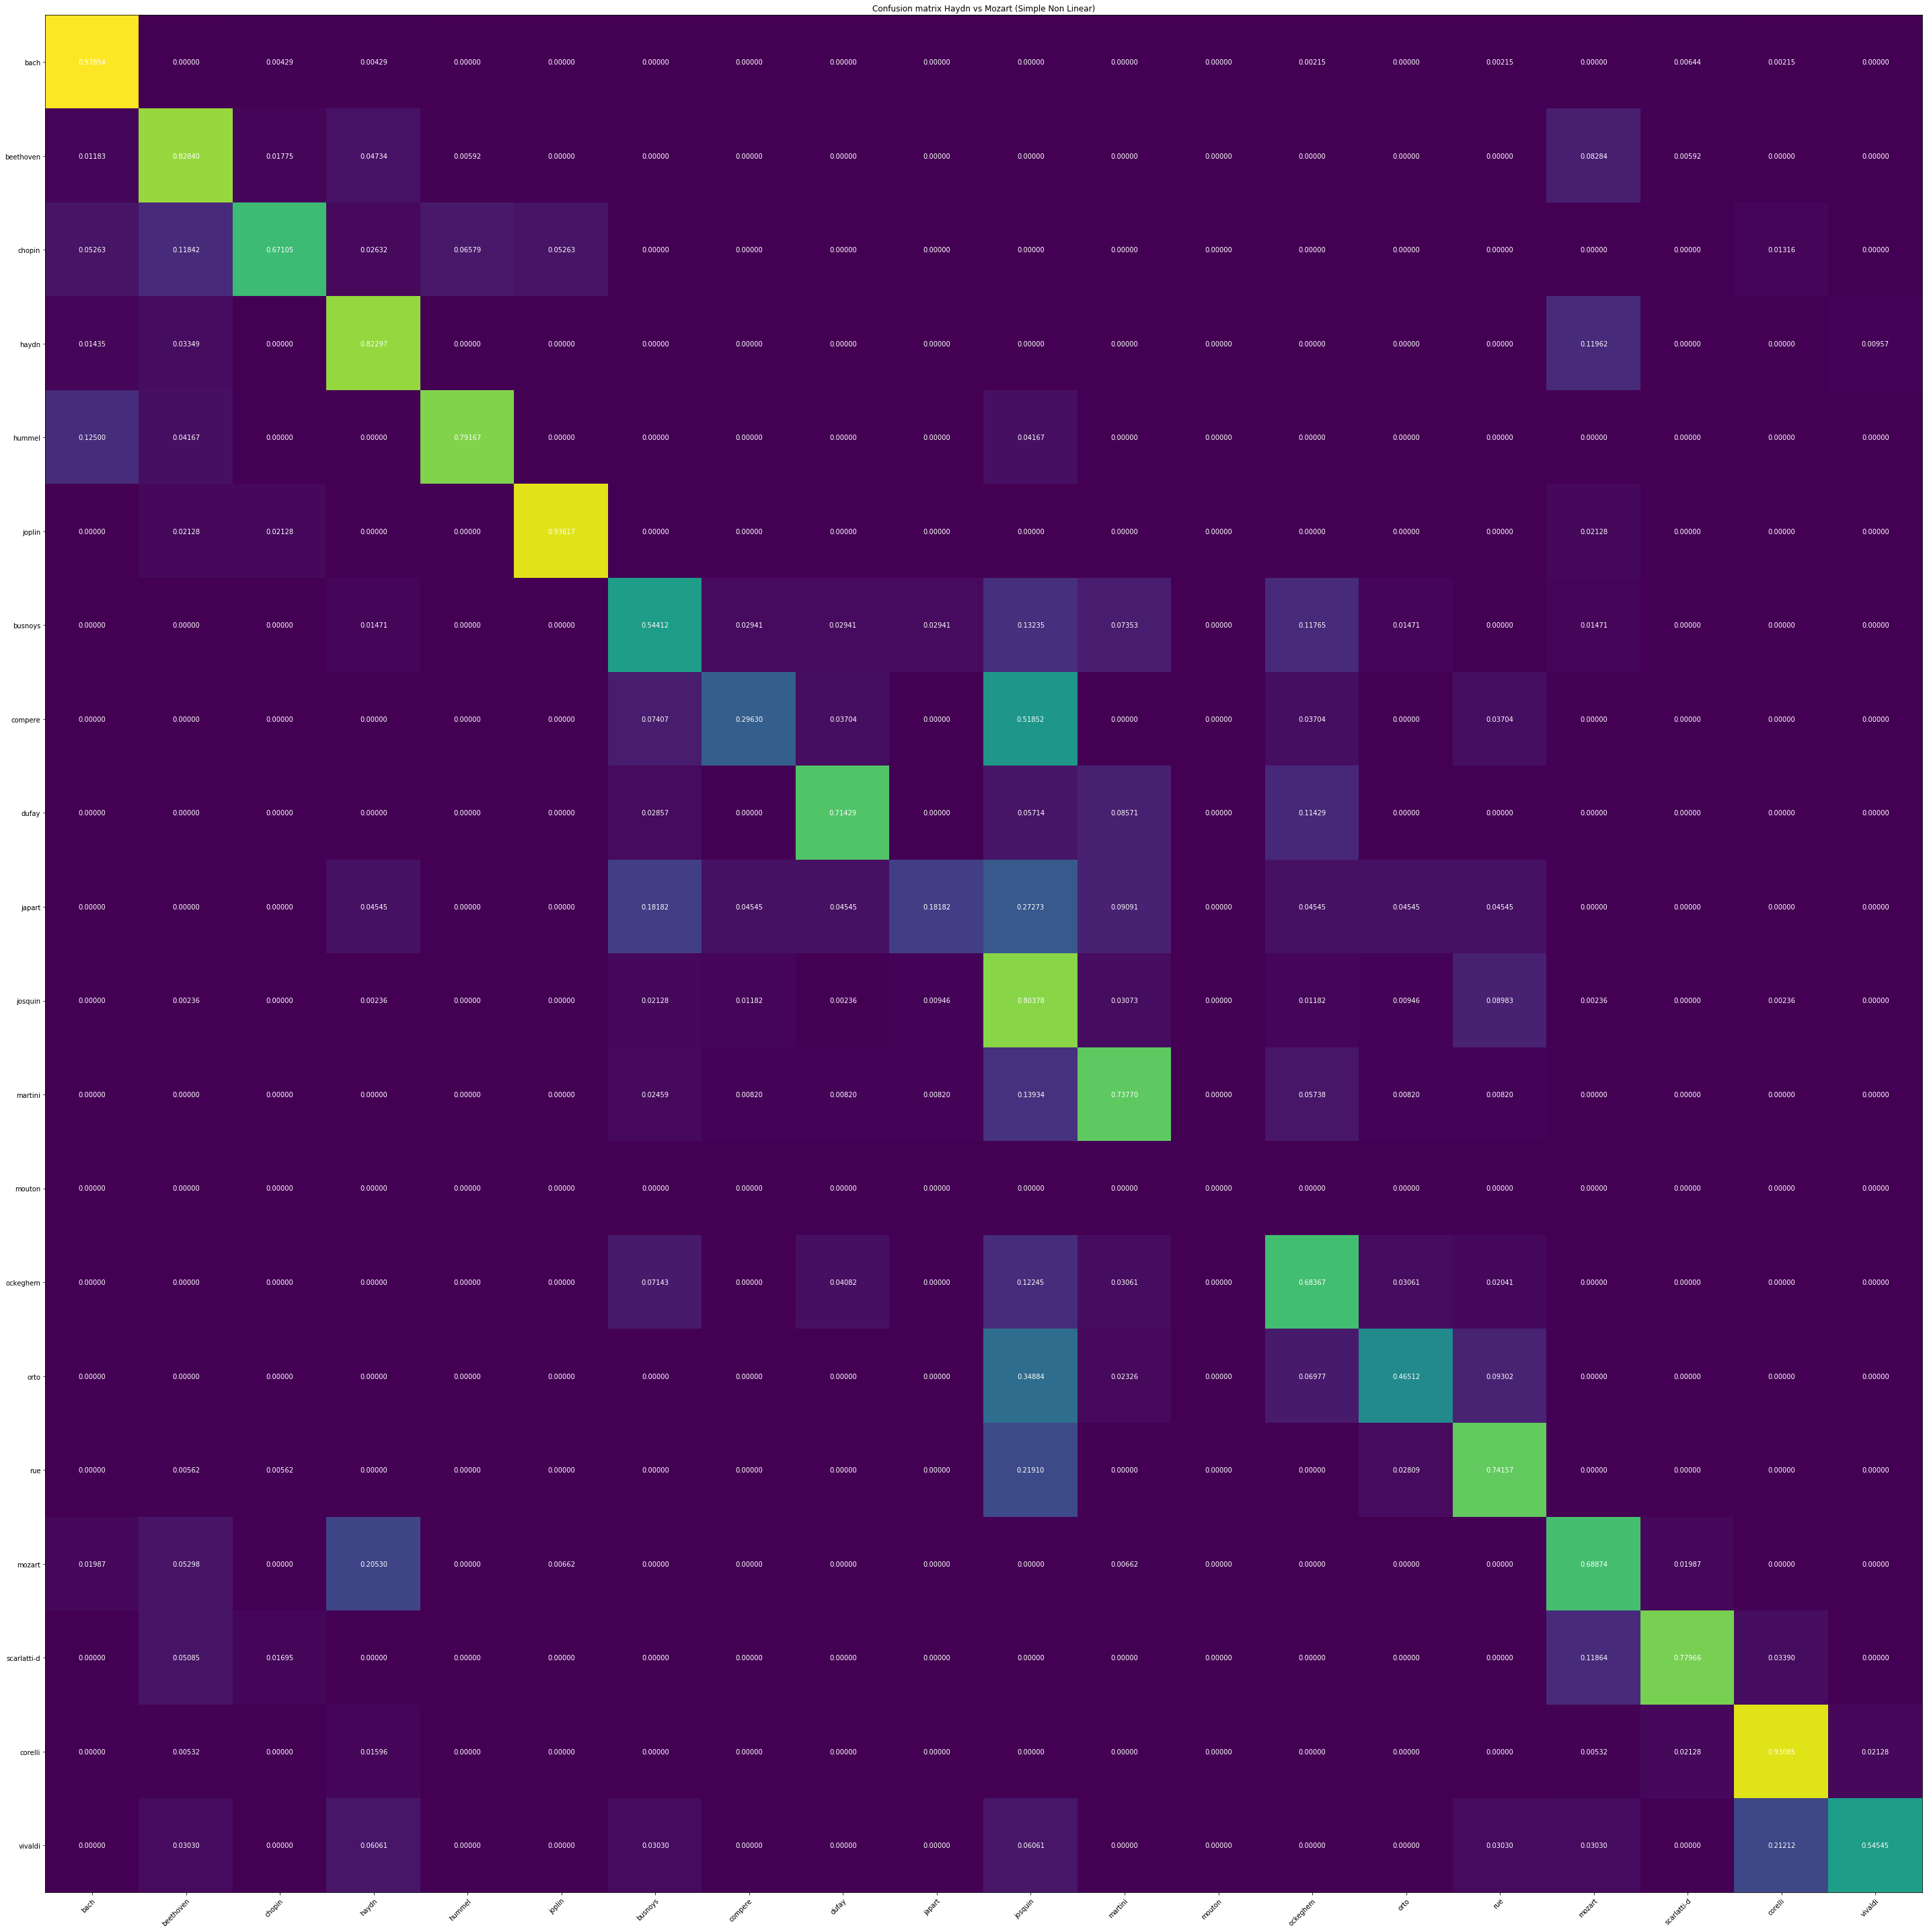

bach 51 / 52 = 0.9807692307692307
beethoven 19 / 25 = 0.76
busnoys 6 / 14 = 0.42857142857142855
chopin 8 / 13 = 0.6153846153846154
compere 2 / 9 = 0.2222222222222222
corelli 26 / 26 = 1.0
dufay 6 / 8 = 0.75
haydn 23 / 29 = 0.7931034482758621
hummel 4 / 6 = 0.6666666666666666
japart 1 / 4 = 0.25
joplin 11 / 11 = 1.0
josquin 35 / 45 = 0.7777777777777778
martini 12 / 14 = 0.8571428571428571
mozart 17 / 25 = 0.68
ockeghem 14 / 17 = 0.8235294117647058
orto 1 / 7 = 0.14285714285714285
rue 20 / 25 = 0.8
scarlatti-d 12 / 14 = 0.8571428571428571
vivaldi 4 / 6 = 0.6666666666666666
272 350 0.7771428571428571
Final real overall test accuracy: 0.7990155865463495 (1948/2438)
  bach: 0.9785407725321889 (456/466)
  beethoven: 0.8284023668639053 (140/169)
  chopin: 0.6710526315789473 (51/76)
  haydn: 0.8229665071770335 (172/209)
  hummel: 0.7916666666666666 (19/24)
  joplin: 0.9361702127659575 (44/47)
  busnoys: 0.5441176470588235 (37/68)
  compere: 0.2962962962962963 (8/27)
  dufay: 0.7142857142857143

/home/thickstn/composers/lib/CrossValidation.py:243: RuntimeWarning: invalid value encountered in double_scalars
  accuracy = correct / float(total_scores)


In [4]:
validator = CrossValidator(Convnet, corpora, is_patches_model=True, patience=30, batch_size=32)
validator.run(context, checkpoint_dir=checkpoint_dir)